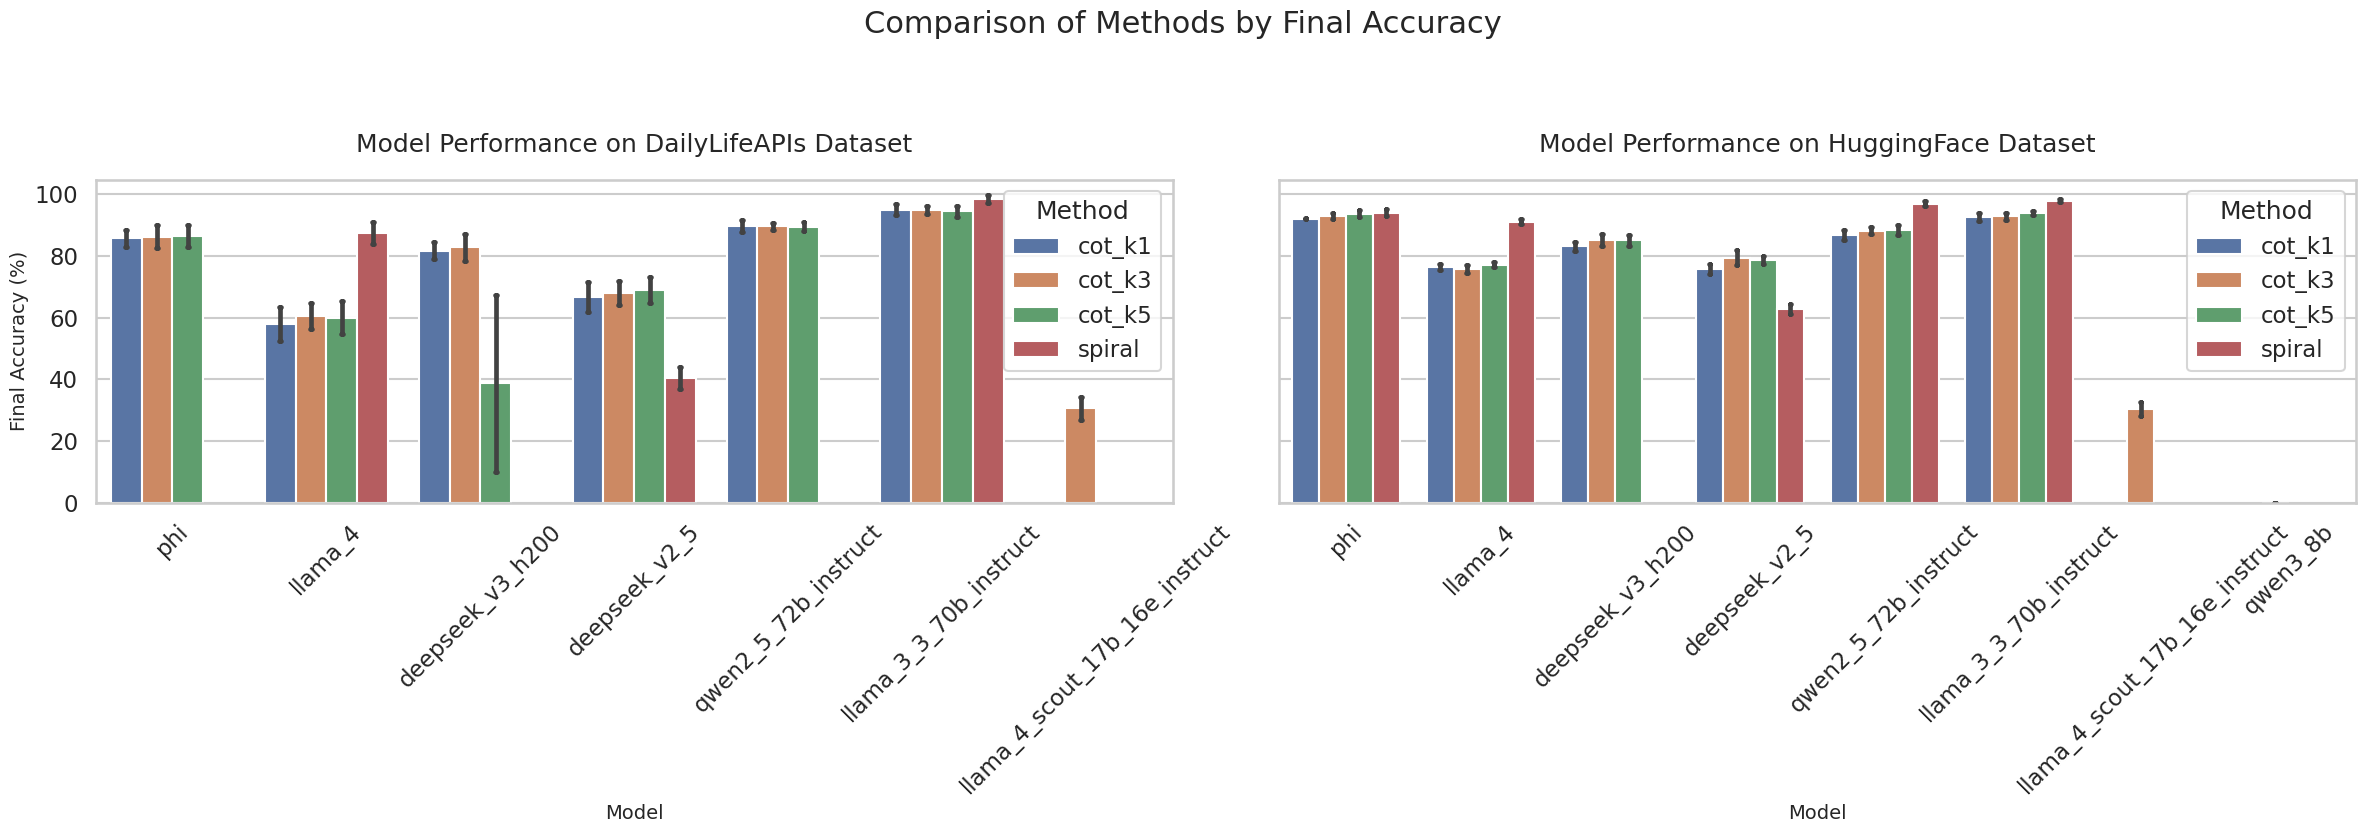

In [7]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# --- 1. Data Parsing ---
# This part finds and processes all 'summary.json' files.

# Define the root directory (current directory, since the notebook is in RQ1)
root_dir = Path('.') 
experiment_data = []

# Find all summary.json files within the subdirectories
summary_files = root_dir.glob('**/summary.json')

for file_path in summary_files:
    try:
        # Extract metadata from the file path.
        # e.g., parts = ('cot_k1', 'dailylifeapis_experiments', 'llama_4', ...)
        parts = file_path.parent.parts
        
        # Ensure the path is long enough to contain the required parts
        if len(parts) >= 4:
            method = parts[-4]
            dataset = parts[-3].replace('_experiments', '')
            model = parts[-2]

            # Read the JSON data
            with open(file_path, 'r') as f:
                data = json.load(f)
            
            # Extract accuracy, remove '%' and convert to float
            accuracy_str = data.get('final_accuracy', '0%')
            accuracy = float(accuracy_str.strip('%'))
            
            experiment_data.append({
                'method': method,
                'dataset': dataset,
                'model': model,
                'accuracy': accuracy
            })

    except (IndexError, json.JSONDecodeError, ValueError) as e:
        print(f"Skipping file due to error: {file_path} -> {e}")

# Create a pandas DataFrame from the collected data
df = pd.DataFrame(experiment_data)

# --- 2. Data Visualization ---
# This part creates the plots using the processed DataFrame.

if not df.empty:
    # Set plot style and context for better aesthetics
    sns.set_theme(style="whitegrid")
    sns.set_context("talk")

    # Get the list of unique datasets
    datasets = df['dataset'].unique()
    
    # Create subplots, one for each dataset
    fig, axes = plt.subplots(1, len(datasets), figsize=(12 * len(datasets), 8), sharey=True)
    if len(datasets) == 1: # Ensure axes is always iterable
        axes = [axes]

    # Define a consistent order for methods for plotting
    method_order = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']
    
    for i, dataset_name in enumerate(datasets):
        ax = axes[i]
        # Filter data for the current dataset
        dataset_df = df[df['dataset'] == dataset_name]
        
        # Create the bar plot
        # seaborn automatically calculates the mean and standard deviation (errorbar='sd')
        sns.barplot(
            data=dataset_df,
            x='model',
            y='accuracy',
            hue='method',
            hue_order=[m for m in method_order if m in dataset_df['method'].unique()],
            ax=ax,
            errorbar='sd',  # Use standard deviation for error bars
            capsize=.05
        )
        
        # Customize the plot
        dataset_title = 'DailyLifeAPIs' if 'dailylife' in dataset_name else 'HuggingFace'
        ax.set_title(f'Model Performance on {dataset_title} Dataset', fontsize=18, pad=20)
        ax.set_xlabel('Model', fontsize=14)
        ax.set_ylabel('Final Accuracy (%)' if i == 0 else '', fontsize=14)
        ax.tick_params(axis='x', rotation=45)
        ax.legend(title='Method')

    # Adjust layout and display the plot
    plt.suptitle('Comparison of Methods by Final Accuracy', fontsize=22, y=1.05)
    plt.tight_layout()
    plt.show()

else:
    print("No data was loaded. Please check the file paths and JSON format.")

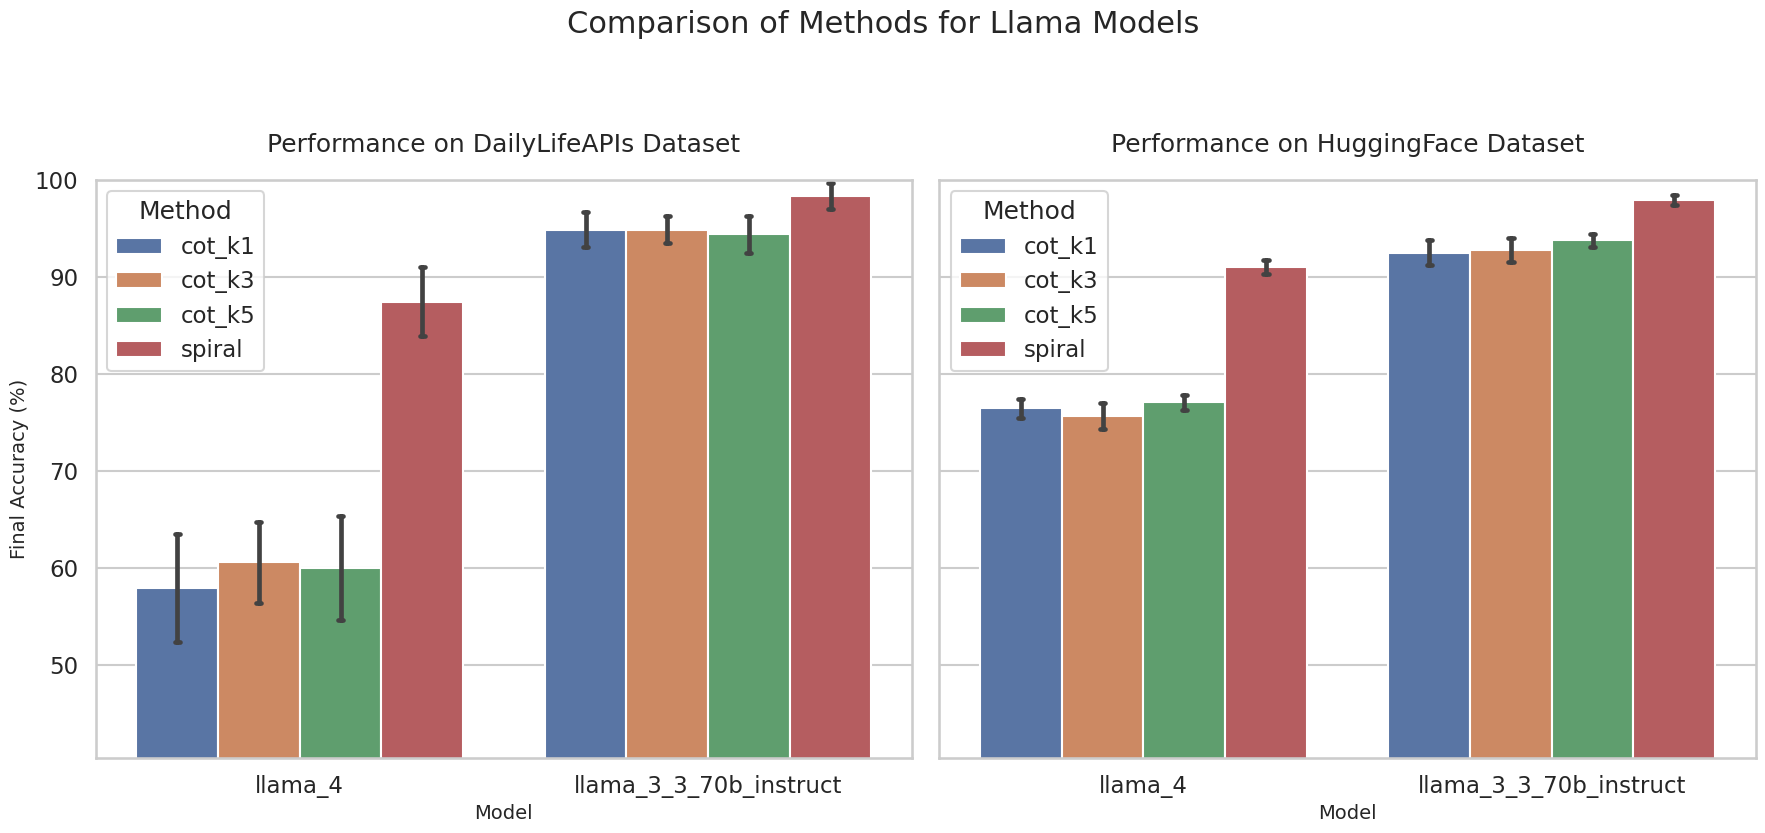

In [1]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np # Import numpy for nanmin

# --- 1. Data Parsing (Same as before) ---
root_dir = Path('.') 
experiment_data = []
summary_files = root_dir.glob('**/summary.json')

for file_path in summary_files:
    try:
        parts = file_path.parent.parts
        if len(parts) >= 4:
            method = parts[-4]
            dataset = parts[-3].replace('_experiments', '')
            model = parts[-2]

            with open(file_path, 'r') as f:
                data = json.load(f)
            
            accuracy_str = data.get('final_accuracy', '0%')
            accuracy = float(accuracy_str.strip('%'))
            
            experiment_data.append({
                'method': method,
                'dataset': dataset,
                'model': model,
                'accuracy': accuracy
            })
    except (IndexError, json.JSONDecodeError, ValueError) as e:
        print(f"Skipping file due to error: {file_path} -> {e}")

df = pd.DataFrame(experiment_data)

# --- 2. Data Filtering and Visualization ---

# ✨ NEW: Filter for specific models
models_to_keep = ['llama_4', 'llama_3_3_70b_instruct']
df_filtered = df[df['model'].isin(models_to_keep)].copy() # Use .copy() to avoid SettingWithCopyWarning

if not df_filtered.empty:
    # ✨ NEW: Calculate the minimum accuracy to adjust the y-axis
    # Using np.nanmin is safe in case of any NaN values
    min_accuracy = np.nanmin(df_filtered['accuracy'])
    # Set the bottom of the y-axis slightly below the minimum value
    y_axis_bottom = max(0, min_accuracy - 10) # Start 10 points below min, but not less than 0

    sns.set_theme(style="whitegrid")
    sns.set_context("talk")

    datasets = df_filtered['dataset'].unique()
    
    # ✨ UPDATED: Adjusted figure size for fewer models
    fig, axes = plt.subplots(1, len(datasets), figsize=(18, 8), sharey=True)
    if len(datasets) == 1:
        axes = [axes]

    method_order = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']
    
    for i, dataset_name in enumerate(datasets):
        ax = axes[i]
        dataset_df = df_filtered[df_filtered['dataset'] == dataset_name]
        
        sns.barplot(
            data=dataset_df,
            x='model',
            y='accuracy',
            hue='method',
            hue_order=[m for m in method_order if m in dataset_df['method'].unique()],
            ax=ax,
            errorbar='sd',
            capsize=.05
        )
        
        dataset_title = 'DailyLifeAPIs' if 'dailylife' in dataset_name else 'HuggingFace'
        ax.set_title(f'Performance on {dataset_title} Dataset', fontsize=18, pad=20)
        ax.set_xlabel('Model', fontsize=14)
        ax.set_ylabel('Final Accuracy (%)' if i == 0 else '', fontsize=14)
        ax.tick_params(axis='x', rotation=0) # No rotation needed for two models
        
        # ✨ NEW: Set the y-axis limits
        ax.set_ylim(bottom=y_axis_bottom, top=100)
        
        # Adjust legend position
        ax.legend(title='Method', loc='upper left')

    plt.suptitle('Comparison of Methods for Llama Models', fontsize=22, y=1.05)
    plt.tight_layout()
    plt.show()

else:
    print("No data found for the specified models ('llama_4', 'llama_3_3_70b_instruct').")

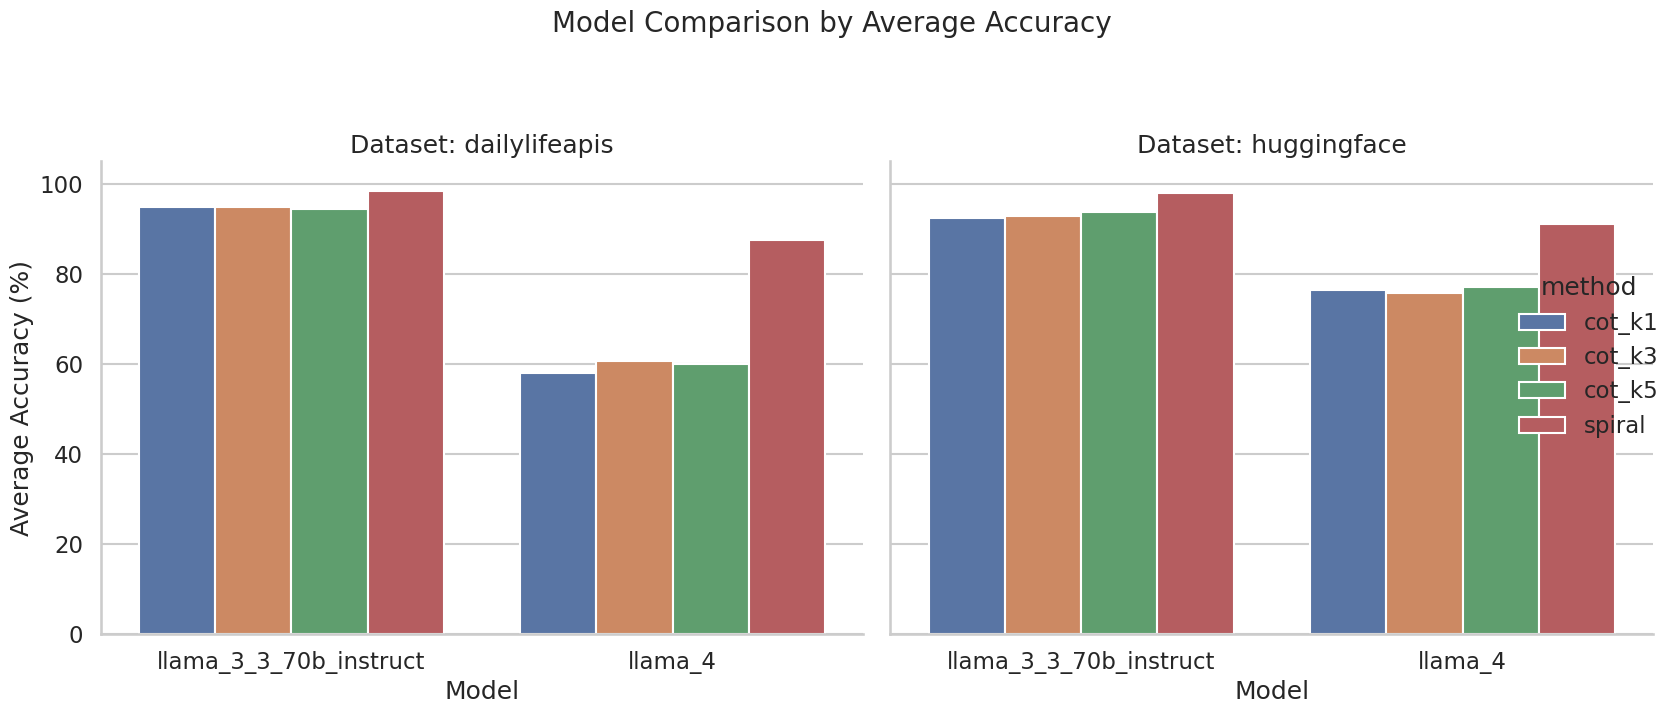

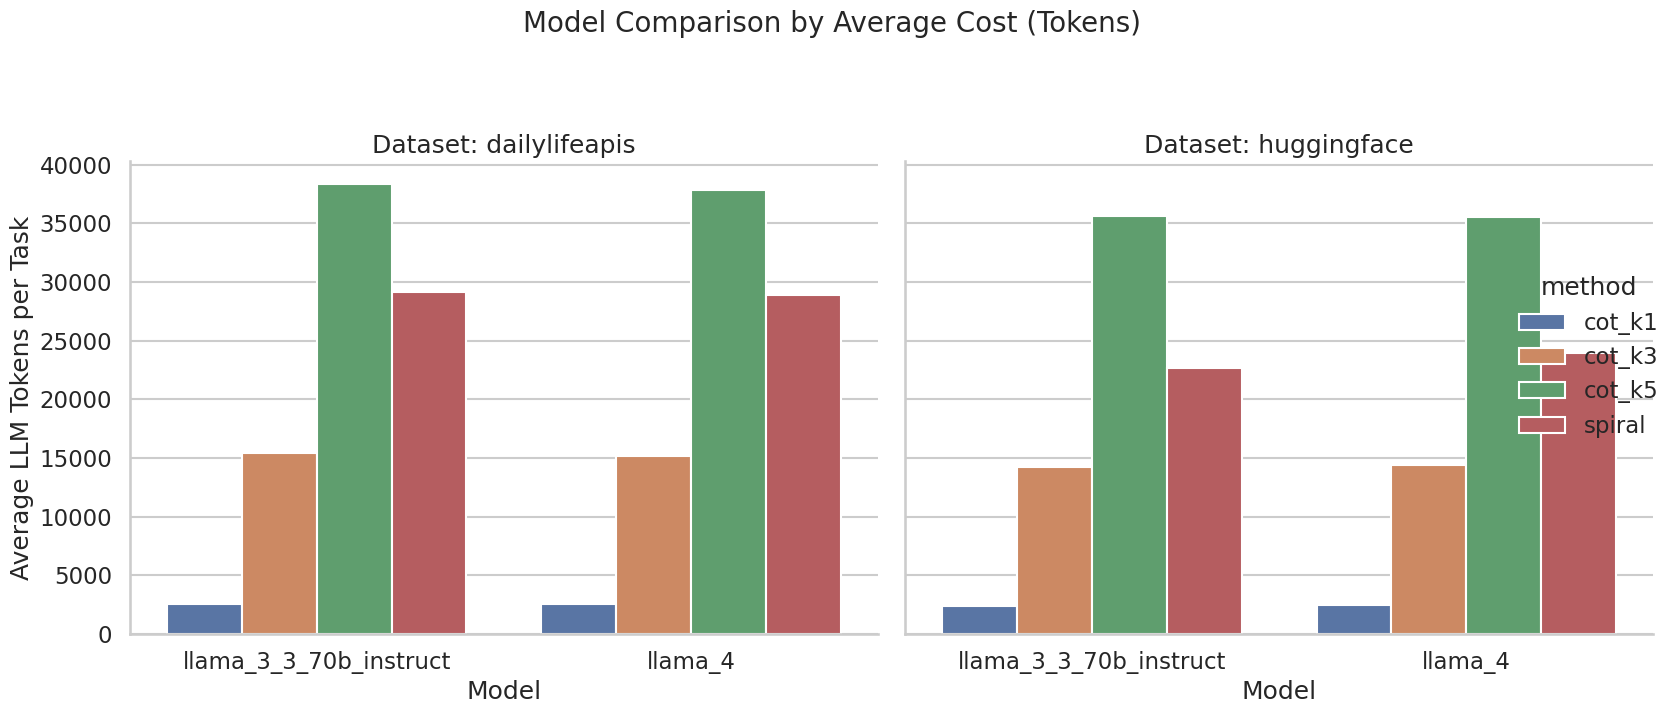

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# --- 1. Robust Data Parsing (Same as before) ---
root_dir = Path('.')
detailed_data = []
ALL_EXPECTED_METHODS = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']
results_files = root_dir.glob('**/results.json')

for file_path in results_files:
    try:
        parts = file_path.parts
        current_method = None
        for m in ALL_EXPECTED_METHODS:
            if m in parts:
                current_method = m
                break
        
        if current_method:
            method_index = parts.index(current_method)
            dataset = parts[method_index + 1].replace('_experiments', '')
            model = parts[method_index + 2]

            with open(file_path, 'r') as f:
                results_list = json.load(f)

            for item in results_list:
                metrics = item.get('metrics', {})
                total_tokens = None

                if current_method in ['cot_k1', 'cot_k3', 'cot_k5']:
                    reasoning_cost = metrics.get('reasoning_cost', {})
                    total_tokens = reasoning_cost.get('total_llm_tokens')
                elif current_method == 'spiral':
                    search_process = metrics.get('search_process', {})
                    exp_tokens = search_process.get('expansion_llm_tokens', 0)
                    sim_tokens = search_process.get('simulation_llm_tokens', 0)
                    crit_tokens = search_process.get('critic_llm_tokens', 0)
                    total_tokens = exp_tokens + sim_tokens + crit_tokens
                
                detailed_data.append({
                    'method': current_method, 'dataset': dataset, 'model': model,
                    'accuracy': metrics.get('accuracy'), 'plan_length': metrics.get('plan_length'),
                    'total_llm_tokens': total_tokens
                })
    except Exception as e:
        print(f"🔴 Skipping file due to error: {file_path} -> {e}")

# --- 2. Diagnostics and Filtering (Same as before) ---
df_raw = pd.DataFrame(detailed_data)
df_cleaned = df_raw.dropna(subset=['accuracy', 'plan_length', 'total_llm_tokens']).copy()
models_to_keep = ['llama_4', 'llama_3_3_70b_instruct', 'phi',]
df_filtered = df_cleaned[df_cleaned['model'].isin(models_to_keep)].copy()


# --- 3. Generate Bar Plots ---
if not df_filtered.empty:
    agg_df = df_filtered.groupby(['method', 'dataset', 'model']).agg(
        avg_accuracy=('accuracy', 'mean'),
        avg_tokens=('total_llm_tokens', 'mean'),
    ).reset_index()
    agg_df['avg_accuracy'] = agg_df['avg_accuracy'] * 100

    sns.set_theme(style="whitegrid", context="talk")
    plot_method_order = [m for m in ALL_EXPECTED_METHODS if m in agg_df['method'].unique()]

    # ✨ Plot 1: Average Accuracy Bar Plot ✨
    g_acc = sns.catplot(
        data=agg_df,
        kind='bar',
        x='model',
        y='avg_accuracy',
        hue='method',
        hue_order=plot_method_order,
        col='dataset',
        height=7,
        aspect=1.1
    )
    g_acc.fig.suptitle('Model Comparison by Average Accuracy', y=1.03, fontsize=20)
    g_acc.set_axis_labels("Model", "Average Accuracy (%)")
    g_acc.set_titles("Dataset: {col_name}")
    g_acc.set(ylim=(0, 105)) # Set y-axis to be 0-100%
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    # ✨ Plot 2: Average Cost Bar Plot ✨
    g_cost = sns.catplot(
        data=agg_df,
        kind='bar',
        x='model',
        y='avg_tokens',
        hue='method',
        hue_order=plot_method_order,
        col='dataset',
        height=7,
        aspect=1.1
    )
    g_cost.fig.suptitle('Model Comparison by Average Cost (Tokens)', y=1.03, fontsize=20)
    g_cost.set_axis_labels("Model", "Average LLM Tokens per Task")
    g_cost.set_titles("Dataset: {col_name}")
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    plt.show()

else:
    print("🔴 No data available for plotting after filtering.")

In [4]:
# import json
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from pathlib import Path

# # --- 1. Robust Data Parsing for All Metrics ---
# root_dir = Path('.')
# detailed_data = []
# ALL_EXPECTED_METHODS = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']
# results_files = root_dir.glob('**/results.json')

# for file_path in results_files:
#     try:
#         parts = file_path.parts
#         current_method = None
#         for m in ALL_EXPECTED_METHODS:
#             if m in parts:
#                 current_method = m
#                 break
        
#         if current_method:
#             method_index = parts.index(current_method)
#             dataset = parts[method_index + 1].replace('_experiments', '')
#             model = parts[method_index + 2]

#             with open(file_path, 'r') as f:
#                 results_list = json.load(f)

#             for item in results_list:
#                 metrics = item.get('metrics', {})
#                 total_tokens = None
#                 generation_time = None # ✨ Initialize time metric

#                 if current_method in ['cot_k1', 'cot_k3', 'cot_k5']:
#                     reasoning_cost = metrics.get('reasoning_cost', {})
#                     total_tokens = reasoning_cost.get('total_llm_tokens')
#                     generation_time = metrics.get('generation_time_seconds') # ✨ Get CoT time
#                 elif current_method == 'spiral':
#                     search_process = metrics.get('search_process', {})
#                     exp_tokens = search_process.get('expansion_llm_tokens', 0)
#                     sim_tokens = search_process.get('simulation_llm_tokens', 0)
#                     crit_tokens = search_process.get('critic_llm_tokens', 0)
#                     total_tokens = exp_tokens + sim_tokens + crit_tokens
#                     generation_time = metrics.get('search_time_seconds') # ✨ Get Spiral time
                
#                 detailed_data.append({
#                     'method': current_method, 'dataset': dataset, 'model': model,
#                     'accuracy': metrics.get('accuracy'), 'plan_length': metrics.get('plan_length'),
#                     'total_llm_tokens': total_tokens,
#                     'generation_time': generation_time # ✨ Add time to data
#                 })
#     except Exception as e:
#         print(f"🔴 Skipping file due to error: {file_path} -> {e}")

# # --- 2. Diagnostics and Filtering ---
# df_raw = pd.DataFrame(detailed_data)
# # ✨ Update dropna to include the new time metric
# df_cleaned = df_raw.dropna(subset=['accuracy', 'plan_length', 'total_llm_tokens', 'generation_time']).copy()
# models_to_keep = ['llama_4', 'llama_3_3_70b_instruct']
# df_filtered = df_cleaned[df_cleaned['model'].isin(models_to_keep)].copy()


# # --- 3. Generate New Bar Plots ---
# if not df_filtered.empty:
#     # ✨ Update aggregation to include the new metrics
#     agg_df = df_filtered.groupby(['method', 'dataset', 'model']).agg(
#         avg_time=('generation_time', 'mean'),
#         avg_plan_length=('plan_length', 'mean')
#     ).reset_index()

#     sns.set_theme(style="whitegrid", context="talk")
#     plot_method_order = [m for m in ALL_EXPECTED_METHODS if m in agg_df['method'].unique()]

#     # ✨ Plot 1: Average Generation Time Bar Plot ✨
#     g_time = sns.catplot(
#         data=agg_df,
#         kind='bar',
#         x='model',
#         y='avg_time',
#         hue='method',
#         hue_order=plot_method_order,
#         col='dataset',
#         height=7,
#         aspect=1.1
#     )
#     g_time.fig.suptitle('Model Comparison by Average Generation Time (Latency)', y=1.03, fontsize=20)
#     g_time.set_axis_labels("Model", "Average Time (s)")
#     g_time.set_titles("Dataset: {col_name}")
#     plt.tight_layout(rect=[0, 0, 1, 0.97])
    
#     # ✨ Plot 2: Average Plan Length Bar Plot ✨
#     g_plan = sns.catplot(
#         data=agg_df,
#         kind='bar',
#         x='model',
#         y='avg_plan_length',
#         hue='method',
#         hue_order=plot_method_order,
#         col='dataset',
#         height=7,
#         aspect=1.1
#     )
#     g_plan.fig.suptitle('Model Comparison by Average Solution Plan Length', y=1.03, fontsize=20)
#     g_plan.set_axis_labels("Model", "Average Plan Length (API calls)")
#     g_plan.set_titles("Dataset: {col_name}")
#     plt.tight_layout(rect=[0, 0, 1, 0.97])
    
#     plt.show()

# else:
#     print("🔴 No data available for plotting after filtering.")


--- 📊 Aggregated Performance Results (TXT) ---

method       dataset                  model  avg_accuracy   avg_tokens
cot_k1 dailylifeapis          deepseek_v2_5     66.609881  2849.763203
cot_k1 dailylifeapis llama_3_3_70b_instruct     94.867550  2577.998344
cot_k1 dailylifeapis                llama_4     57.947020  2535.493377
cot_k1 dailylifeapis                    phi     85.666667  2521.696667
cot_k1 dailylifeapis   qwen2_5_72b_instruct     89.713322  2484.738617
cot_k3 dailylifeapis          deepseek_v2_5     67.892977 17128.936455
cot_k3 dailylifeapis llama_3_3_70b_instruct     94.876033 15384.796694
cot_k3 dailylifeapis                llama_4     60.596026 15180.917219
cot_k3 dailylifeapis                    phi     86.235489 15182.059701
cot_k3 dailylifeapis   qwen2_5_72b_instruct     89.643463 14836.555178
cot_k5 dailylifeapis          deepseek_v2_5     68.822554 42750.237148
cot_k5 dailylifeapis llama_3_3_70b_instruct     94.380165 38354.003306
cot_k5 dailylifeapis        

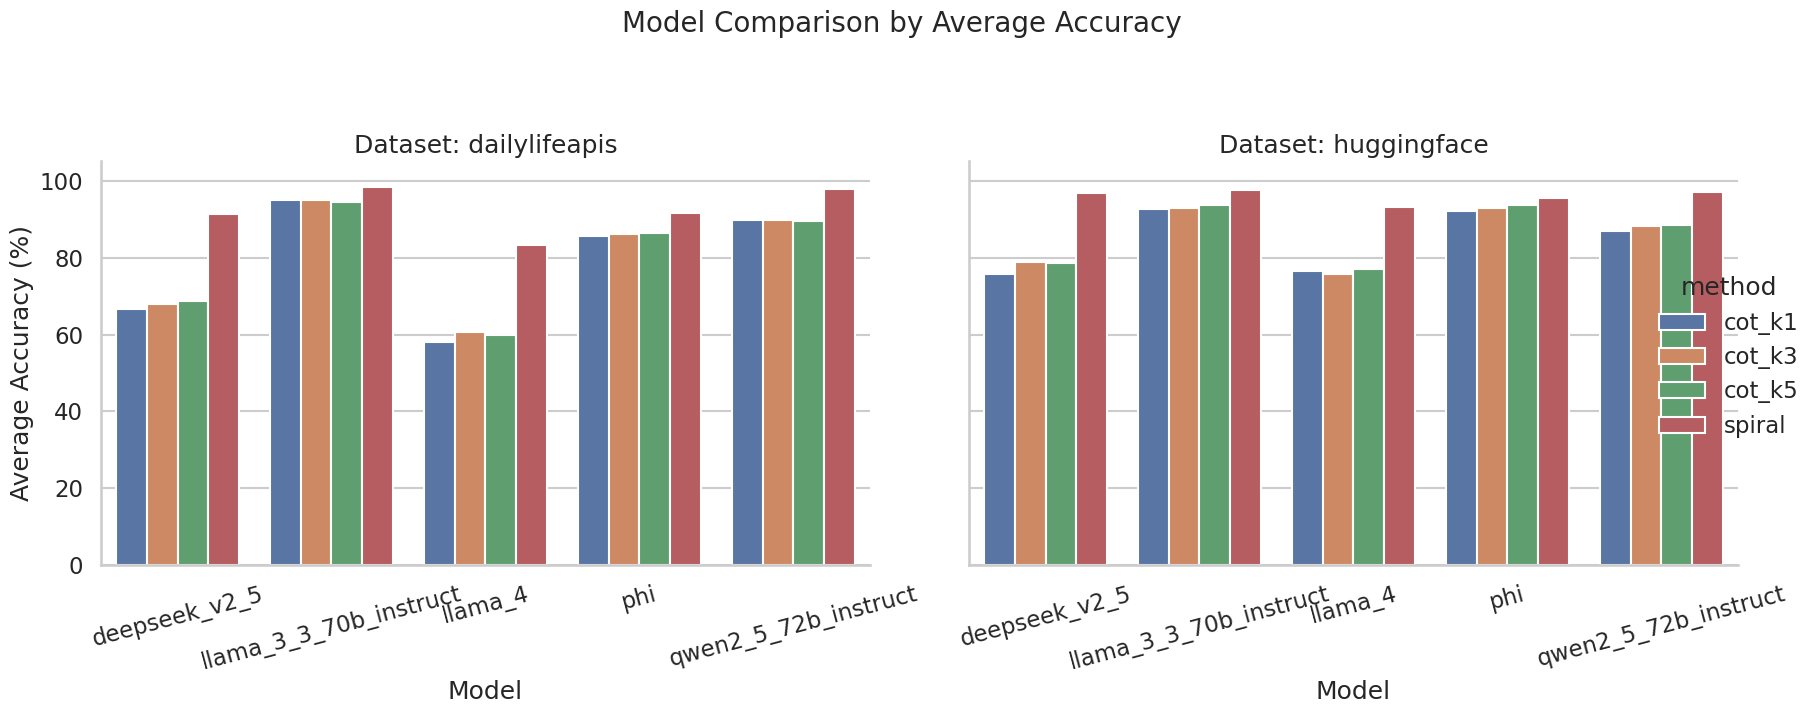

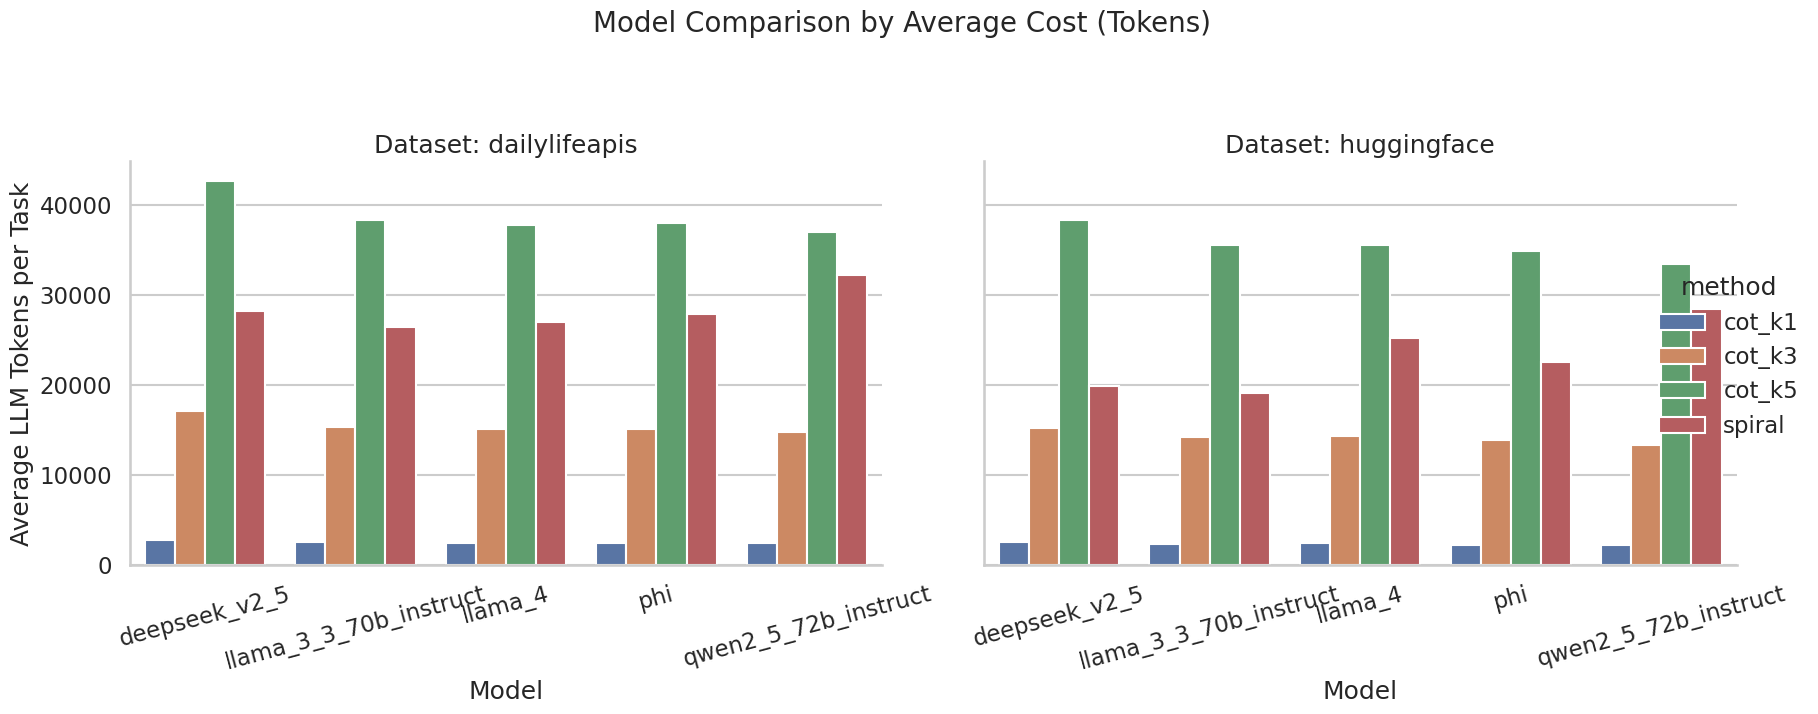

In [4]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# --- 1. Robust Data Parsing ---
# This section remains unchanged, as it correctly parses all found results.
root_dir = Path('.')
detailed_data = []
ALL_EXPECTED_METHODS = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']
results_files = root_dir.glob('**/results.json')

for file_path in results_files:
    try:
        parts = file_path.parts
        current_method = None
        for m in ALL_EXPECTED_METHODS:
            if m in parts:
                current_method = m
                break
        
        if current_method:
            method_index = parts.index(current_method)
            dataset = parts[method_index + 1].replace('_experiments', '')
            model = parts[method_index + 2]

            with open(file_path, 'r') as f:
                results_list = json.load(f)

            for item in results_list:
                metrics = item.get('metrics', {})
                total_tokens = None

                if current_method in ['cot_k1', 'cot_k3', 'cot_k5']:
                    reasoning_cost = metrics.get('reasoning_cost', {})
                    total_tokens = reasoning_cost.get('total_llm_tokens')
                elif current_method == 'spiral':
                    search_process = metrics.get('search_process', {})
                    exp_tokens = search_process.get('expansion_llm_tokens', 0)
                    sim_tokens = search_process.get('simulation_llm_tokens', 0)
                    crit_tokens = search_process.get('critic_llm_tokens', 0)
                    total_tokens = exp_tokens + sim_tokens + crit_tokens
                
                detailed_data.append({
                    'method': current_method, 'dataset': dataset, 'model': model,
                    'accuracy': metrics.get('accuracy'), 'plan_length': metrics.get('plan_length'),
                    'total_llm_tokens': total_tokens
                })
    except Exception as e:
        print(f"🔴 Skipping file due to error: {file_path} -> {e}")

# --- 2. Diagnostics and Filtering ---
df_raw = pd.DataFrame(detailed_data)
df_cleaned = df_raw.dropna(subset=['accuracy', 'plan_length', 'total_llm_tokens']).copy()

# ✨ MODIFICATION: Include all 5 models for comparison
models_to_keep = [
    'deepseek_v2_5', 
    'llama_3_3_70b_instruct', 
    'llama_4', 
    'phi', 
    'qwen2_5_72b_instruct'
]
df_filtered = df_cleaned[df_cleaned['model'].isin(models_to_keep)].copy()

# --- 3. Aggregate Data ---
if not df_filtered.empty:
    agg_df = df_filtered.groupby(['method', 'dataset', 'model']).agg(
        avg_accuracy=('accuracy', 'mean'),
        avg_tokens=('total_llm_tokens', 'mean'),
    ).reset_index()
    agg_df['avg_accuracy'] = agg_df['avg_accuracy'] * 100

    # ✨ MODIFICATION: Define the neutral (alphabetical) order for models
    model_order_neutral = [
        'deepseek_v2_5', 
        'llama_3_3_70b_instruct', 
        'llama_4', 
        'phi', 
        'qwen2_5_72b_instruct'
    ]
    
    # Ensure the 'model' column is sorted according to the neutral order
    agg_df['model'] = pd.Categorical(agg_df['model'], categories=model_order_neutral, ordered=True)
    agg_df = agg_df.sort_values(by=['dataset', 'method', 'model'])

    # --- 4. ✍️ Generate Text Result ---
    print("\n--- 📊 Aggregated Performance Results (TXT) ---\n")
    # Set pandas display options to show all rows and columns for clarity
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(agg_df.to_string(index=False))
    print("\n" + "="*50 + "\n") # Separator before plots appear

    # --- 5. 🖼️ Generate Bar Plots ---
    sns.set_theme(style="whitegrid", context="talk")
    plot_method_order = [m for m in ALL_EXPECTED_METHODS if m in agg_df['method'].unique()]

    # Plot 1: Average Accuracy Bar Plot
    g_acc = sns.catplot(
        data=agg_df,
        kind='bar',
        x='model',
        y='avg_accuracy',
        hue='method',
        hue_order=plot_method_order,
        order=model_order_neutral, # ✨ MODIFICATION: Enforce neutral order on plot
        col='dataset',
        height=7,
        aspect=1.2,
        legend_out=True
    )
    g_acc.fig.suptitle('Model Comparison by Average Accuracy', y=1.03, fontsize=20)
    g_acc.set_axis_labels("Model", "Average Accuracy (%)")
    g_acc.set_titles("Dataset: {col_name}")
    g_acc.set(ylim=(0, 105))
    g_acc.set_xticklabels(rotation=15) # Rotate labels slightly for readability
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    # Plot 2: Average Cost Bar Plot
    g_cost = sns.catplot(
        data=agg_df,
        kind='bar',
        x='model',
        y='avg_tokens',
        hue='method',
        hue_order=plot_method_order,
        order=model_order_neutral, # ✨ MODIFICATION: Enforce neutral order on plot
        col='dataset',
        height=7,
        aspect=1.2,
        legend_out=True
    )
    g_cost.fig.suptitle('Model Comparison by Average Cost (Tokens)', y=1.03, fontsize=20)
    g_cost.set_axis_labels("Model", "Average LLM Tokens per Task")
    g_cost.set_titles("Dataset: {col_name}")
    g_cost.set_xticklabels(rotation=15) # Rotate labels slightly for readability
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    plt.show()

else:
    print("🔴 No data available for plotting after filtering for the 5 specified models.")


RQ1: Model Performance Comparison

--- 📊 RQ1 METRICS TABLE ---
dataset                 dailylifeapis  huggingface  Planning Premium
model                                                               
deepseek_v2_5                   73.72        82.72             -9.00
llama_3_3_70b_instruct          95.62        94.12              1.50
llama_4                         65.47        80.64            -15.17
phi                             87.48        93.53             -6.05
qwen2_5_72b_instruct            91.67        90.27              1.40




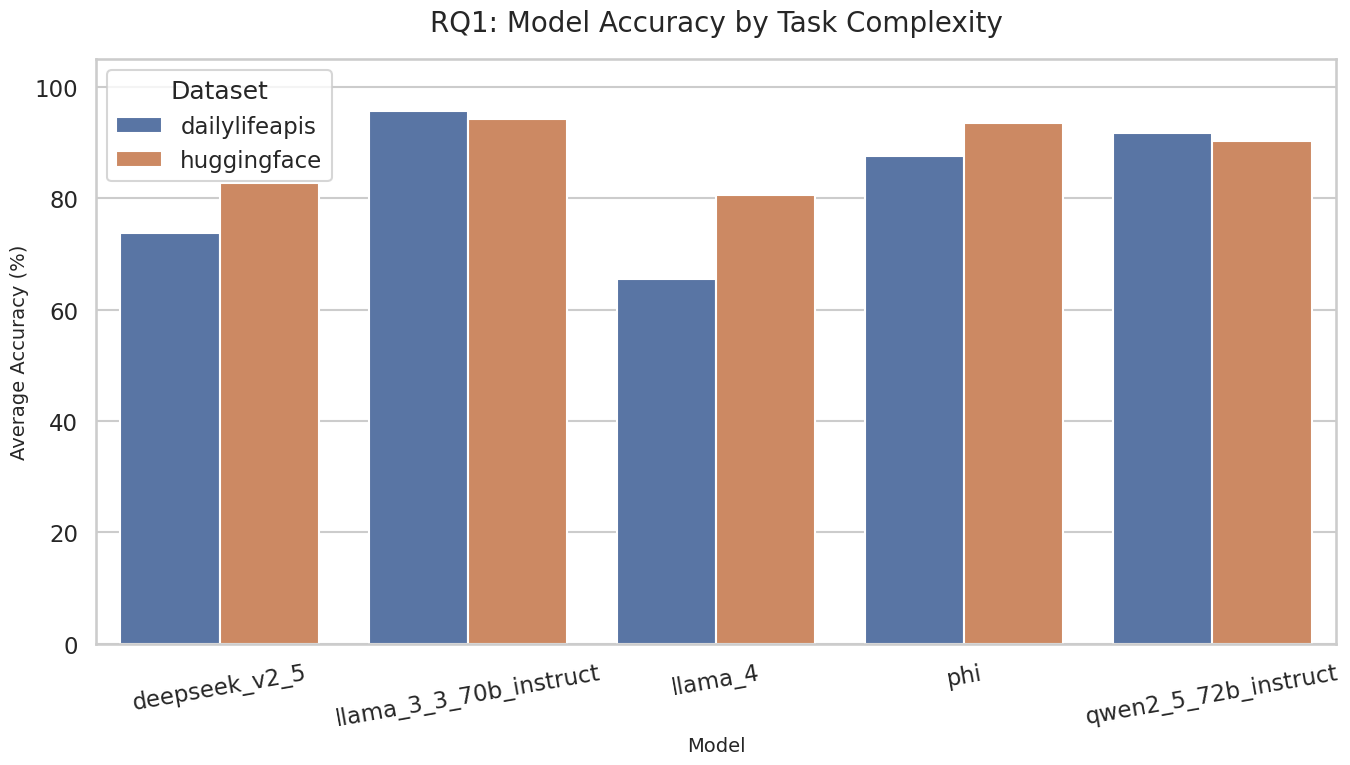

/tmp/ipykernel_344543/3451224480.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(data=rq1_accuracy.reset_index(), x='model', y='Planning Premium',


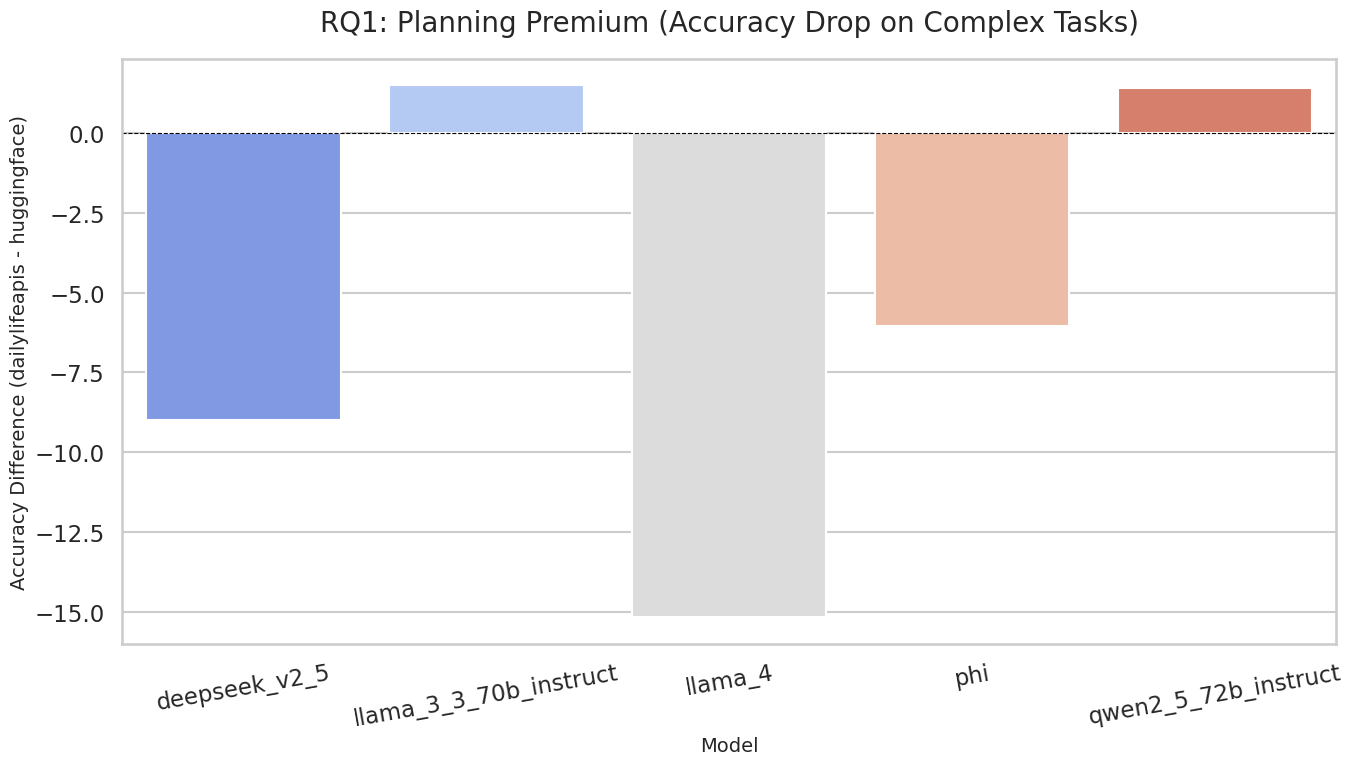


RQ2: Method Performance Comparison (SPIRAL vs. cot_k5)

--- 📊 RQ2 METRICS TABLE ---
method  avg_accuracy  avg_tokens  avg_plan_length  avg_invalid_steps  Efficiency Score
cot_k5         85.04    36257.71             2.71               0.00              8.10
spiral         95.29    24139.99             2.39               0.39              9.44




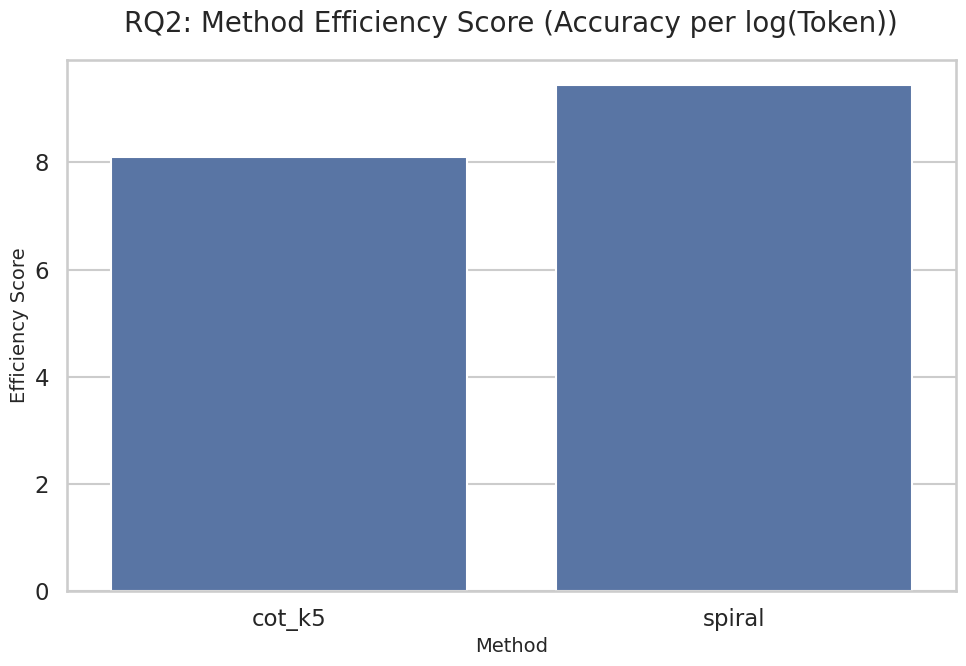

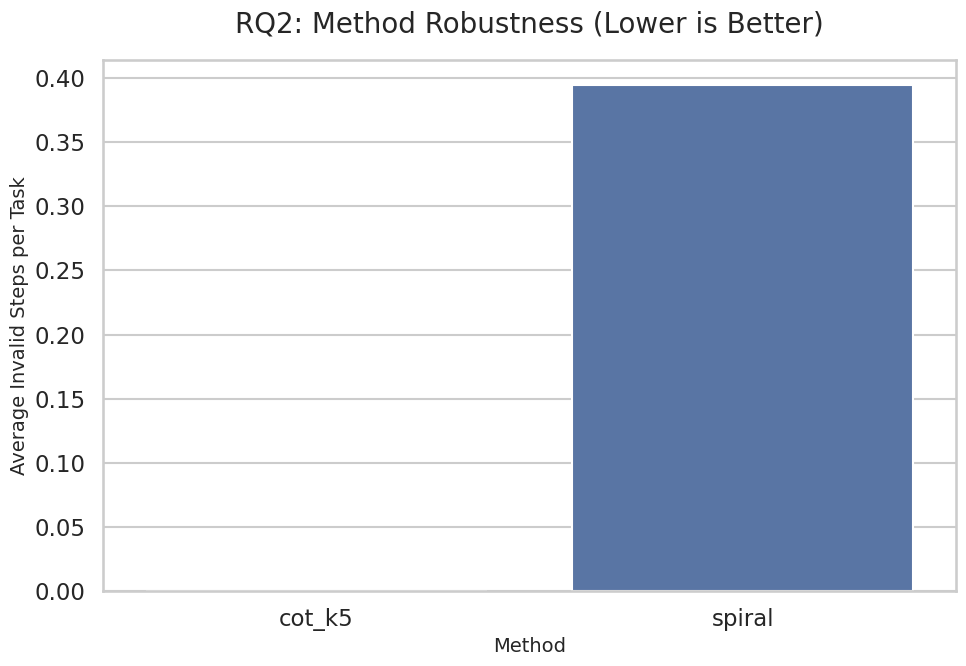

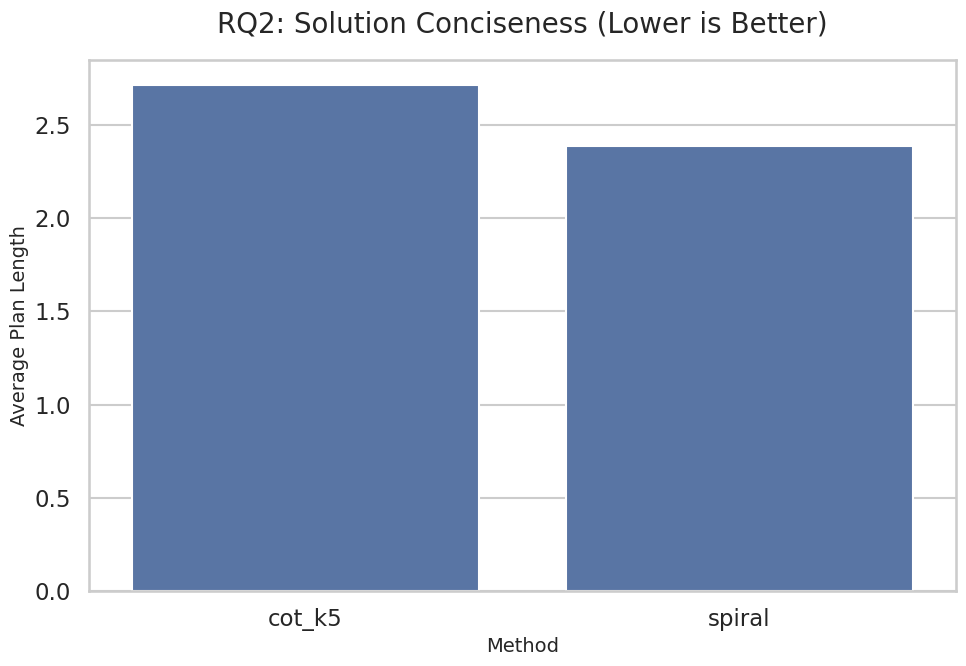

In [5]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

# --- 1. Robust Data Parsing ---
# This section is updated to handle both spiral and baseline metric names.
root_dir = Path('.')
detailed_data = []
ALL_EXPECTED_METHODS = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']
results_files = root_dir.glob('**/results.json')

for file_path in results_files:
    try:
        parts = file_path.parts
        current_method = None
        for m in ALL_EXPECTED_METHODS:
            if m in parts:
                current_method = m
                break
        
        if current_method:
            method_index = parts.index(current_method)
            # Standardize dataset names by removing common suffixes
            dataset = parts[method_index + 1].replace('_experiments', '').replace('_v3', '')
            model = parts[method_index + 2]

            with open(file_path, 'r') as f:
                results_list = json.load(f)

            for item in results_list:
                metrics = item.get('metrics', {})
                total_tokens = None
                latency = None
                invalid_steps = 0 # Default to 0 for baselines

                if current_method == 'spiral':
                    search_process = metrics.get('search_process', {})
                    exp_tokens = search_process.get('expansion_llm_tokens', 0)
                    sim_tokens = search_process.get('simulation_llm_tokens', 0)
                    crit_tokens = search_process.get('critic_llm_tokens', 0)
                    total_tokens = exp_tokens + sim_tokens + crit_tokens
                    latency = metrics.get('search_time_seconds')
                    invalid_steps = metrics.get('robustness', {}).get('invalid_steps_generated', 0)
                else: # Baseline methods (cot_k1, etc.)
                    reasoning_cost = metrics.get('reasoning_cost', {})
                    total_tokens = reasoning_cost.get('total_llm_tokens')
                    latency = metrics.get('generation_time_seconds')

                detailed_data.append({
                    'method': current_method, 'dataset': dataset, 'model': model,
                    'accuracy': metrics.get('accuracy'), 'plan_length': metrics.get('plan_length'),
                    'total_llm_tokens': total_tokens,
                    'latency_seconds': latency,
                    'invalid_steps': invalid_steps
                })
    except Exception as e:
        print(f"🔴 Skipping file due to error: {file_path} -> {e}")

# --- 2. Data Cleaning and Preparation ---
df_raw = pd.DataFrame(detailed_data)
df_cleaned = df_raw.dropna(subset=['accuracy', 'total_llm_tokens']).copy()
df_cleaned['accuracy'] = df_cleaned['accuracy'] * 100 # Convert to percentage

# Define the models and methods for analysis
models_to_keep = [
    'deepseek_v2_5', 'llama_3_3_70b_instruct', 'llama_4', 
    'phi', 'qwen2_5_72b_instruct'
]
methods_to_keep = ['cot_k5', 'spiral'] # Comparing spiral against the strongest baseline

df_models = df_cleaned[df_cleaned['model'].isin(models_to_keep)].copy()
df_methods = df_cleaned[df_cleaned['method'].isin(methods_to_keep)].copy()


# --- 3. RQ1: Model Performance Analysis ---
print("\n" + "="*80)
print("RQ1: Model Performance Comparison")
print("="*80 + "\n")

if not df_models.empty:
    # Calculate task-specific accuracy
    rq1_accuracy = df_models.groupby(['model', 'dataset'])['accuracy'].mean().unstack()
    
    # Calculate Planning Premium
    if 'dailylifeapis' in rq1_accuracy.columns and 'huggingface' in rq1_accuracy.columns:
        rq1_accuracy['Planning Premium'] = rq1_accuracy['dailylifeapis'] - rq1_accuracy['huggingface']
    else:
        print("🔴 Skipping 'Planning Premium' calculation: missing 'dailylifeapis' or 'huggingface' data.")

    # --- Print RQ1 Table ---
    print("--- 📊 RQ1 METRICS TABLE ---")
    print(rq1_accuracy.to_string(float_format="%.2f"))
    print("\n" + "="*80 + "\n")

    # --- Plot RQ1 Metrics ---
    sns.set_theme(style="whitegrid", context="talk")
    
    # Plot 1: Task-Specific Accuracy
    plot_df_rq1_acc = rq1_accuracy.reset_index().melt(id_vars='model', value_vars=['dailylifeapis', 'huggingface'],
                                                     var_name='Dataset', value_name='Average Accuracy')
    plt.figure(figsize=(14, 8))
    ax1 = sns.barplot(data=plot_df_rq1_acc, x='model', y='Average Accuracy', hue='Dataset',
                      order=sorted(models_to_keep))
    ax1.set_title('RQ1: Model Accuracy by Task Complexity', fontsize=20, pad=20)
    ax1.set_xlabel('Model', fontsize=14)
    ax1.set_ylabel('Average Accuracy (%)', fontsize=14)
    ax1.set_ylim(0, 105)
    plt.xticks(rotation=10)
    plt.tight_layout()
    plt.show()

    # Plot 2: Planning Premium
    if 'Planning Premium' in rq1_accuracy.columns:
        plt.figure(figsize=(14, 8))
        ax2 = sns.barplot(data=rq1_accuracy.reset_index(), x='model', y='Planning Premium',
                          order=sorted(models_to_keep), palette='coolwarm')
        ax2.set_title('RQ1: Planning Premium (Accuracy Drop on Complex Tasks)', fontsize=20, pad=20)
        ax2.set_xlabel('Model', fontsize=14)
        ax2.set_ylabel('Accuracy Difference (dailylifeapis - huggingface)', fontsize=14)
        ax2.axhline(0, color='black', linewidth=0.8, linestyle='--')
        plt.xticks(rotation=10)
        plt.tight_layout()
        plt.show()

else:
    print("🔴 No data available for RQ1 analysis.")


# --- 4. RQ2: Method Performance Analysis (SPIRAL vs. Baseline) ---
print("\n" + "="*80)
print("RQ2: Method Performance Comparison (SPIRAL vs. cot_k5)")
print("="*80 + "\n")

if not df_methods.empty:
    # Aggregate data by method
    rq2_agg = df_methods.groupby('method').agg(
        avg_accuracy=('accuracy', 'mean'),
        avg_tokens=('total_llm_tokens', 'mean'),
        avg_plan_length=('plan_length', 'mean'),
        avg_invalid_steps=('invalid_steps', 'mean')
    ).reset_index()

    # Calculate Efficiency Score
    # Adding a small epsilon to avoid log(0) if tokens are 0
    rq2_agg['Efficiency Score'] = rq2_agg['avg_accuracy'] / np.log(rq2_agg['avg_tokens'] + 1e-9)

    # --- Print RQ2 Table ---
    print("--- 📊 RQ2 METRICS TABLE ---")
    print(rq2_agg.to_string(index=False, float_format="%.2f"))
    print("\n" + "="*80 + "\n")
    
    # --- Plot RQ2 Metrics ---
    # Plot 3: Efficiency Score
    plt.figure(figsize=(10, 7))
    ax3 = sns.barplot(data=rq2_agg, x='method', y='Efficiency Score', order=methods_to_keep)
    ax3.set_title('RQ2: Method Efficiency Score (Accuracy per log(Token))', fontsize=20, pad=20)
    ax3.set_xlabel('Method', fontsize=14)
    ax3.set_ylabel('Efficiency Score', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Plot 4: Method Robustness
    plt.figure(figsize=(10, 7))
    ax4 = sns.barplot(data=rq2_agg, x='method', y='avg_invalid_steps', order=methods_to_keep)
    ax4.set_title('RQ2: Method Robustness (Lower is Better)', fontsize=20, pad=20)
    ax4.set_xlabel('Method', fontsize=14)
    ax4.set_ylabel('Average Invalid Steps per Task', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Plot 5: Solution Conciseness
    plt.figure(figsize=(10, 7))
    ax5 = sns.barplot(data=rq2_agg, x='method', y='avg_plan_length', order=methods_to_keep)
    ax5.set_title('RQ2: Solution Conciseness (Lower is Better)', fontsize=20, pad=20)
    ax5.set_xlabel('Method', fontsize=14)
    ax5.set_ylabel('Average Plan Length', fontsize=14)
    plt.tight_layout()
    plt.show()

else:
    print("🔴 No data available for RQ2 analysis.")

In [6]:
import json
import pandas as pd
from pathlib import Path
import numpy as np

# --- 1. Robust Data Parsing ---
# This section remains largely the same, ensuring all required metrics are captured.
root_dir = Path('.')
detailed_data = []
ALL_EXPECTED_METHODS = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']
results_files = root_dir.glob('**/results.json')

for file_path in results_files:
    try:
        parts = file_path.parts
        current_method = None
        for m in ALL_EXPECTED_METHODS:
            if m in parts:
                current_method = m
                break
        
        if current_method:
            method_index = parts.index(current_method)
            # Standardize dataset names
            dataset = parts[method_index + 1].replace('_experiments', '').replace('_v3', '')
            model = parts[method_index + 2]

            with open(file_path, 'r') as f:
                results_list = json.load(f)

            for item in results_list:
                metrics = item.get('metrics', {})
                total_tokens = None

                if current_method == 'spiral':
                    search_process = metrics.get('search_process', {})
                    exp_tokens = search_process.get('expansion_llm_tokens', 0)
                    sim_tokens = search_process.get('simulation_llm_tokens', 0)
                    crit_tokens = search_process.get('critic_llm_tokens', 0)
                    total_tokens = exp_tokens + sim_tokens + crit_tokens
                else: # Baseline methods
                    reasoning_cost = metrics.get('reasoning_cost', {})
                    total_tokens = reasoning_cost.get('total_llm_tokens')

                detailed_data.append({
                    'method': current_method, 'dataset': dataset, 'model': model,
                    'Accuracy': metrics.get('accuracy'),
                    'Plan Length': metrics.get('plan_length'),
                    'Tokens': total_tokens
                })
    except Exception as e:
        print(f"🔴 Skipping file due to error: {file_path} -> {e}")

# --- 2. Data Cleaning and Preparation ---
df_raw = pd.DataFrame(detailed_data)
# Drop rows where any of the essential metrics are missing
df_cleaned = df_raw.dropna(subset=['Accuracy', 'Plan Length', 'Tokens']).copy()
df_cleaned['Accuracy'] = df_cleaned['Accuracy'] * 100 # Convert to percentage

# Define the models and methods for the final table
models_to_keep = [
    'deepseek_v2_5', 'llama_3_3_70b_instruct', 'llama_4', 
    'phi', 'qwen2_5_72b_instruct'
]
methods_to_keep = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']

df_filtered = df_cleaned[
    df_cleaned['model'].isin(models_to_keep) & 
    df_cleaned['method'].isin(methods_to_keep)
].copy()

# --- 3. Aggregate and Restructure Data for Table ---
if not df_filtered.empty:
    # Set categorical types to enforce a specific order in the final table
    df_filtered['model'] = pd.Categorical(df_filtered['model'], categories=sorted(models_to_keep), ordered=True)
    df_filtered['method'] = pd.Categorical(df_filtered['method'], categories=methods_to_keep, ordered=True)

    # Group by all necessary fields and calculate the mean for our metrics
    agg_df = df_filtered.groupby(['dataset', 'model', 'method']).agg({
        'Accuracy': 'mean',
        'Plan Length': 'mean',
        'Tokens': 'mean'
    }).reset_index()

    # Pivot the table to create the desired multi-level column structure
    pivoted = agg_df.pivot_table(
        index=['dataset', 'model'],
        columns='method',
        values=['Accuracy', 'Plan Length', 'Tokens']
    )

    # Reorder columns to group by method, then by metric
    pivoted = pivoted.swaplevel(0, 1, axis=1).sort_index(axis=1)

    # --- 4. Print Formatted Tables ---
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 200) # Adjust width for better console display

    datasets = pivoted.index.get_level_values('dataset').unique()
    
    for dataset_name in datasets:
        print("\n" + "="*100)
        print(f"📊 Results for Dataset: {dataset_name.upper()}")
        print("="*100)
        
        dataset_table = pivoted.loc[dataset_name]
        
        # Define formatting for each column to improve readability
        formatters = {
            ('cot_k1', 'Accuracy'): "{:.2f}%".format,
            ('cot_k3', 'Accuracy'): "{:.2f}%".format,
            ('cot_k5', 'Accuracy'): "{:.2f}%".format,
            ('spiral', 'Accuracy'): "{:.2f}%".format,
            ('cot_k1', 'Plan Length'): "{:.2f}".format,
            ('cot_k3', 'Plan Length'): "{:.2f}".format,
            ('cot_k5', 'Plan Length'): "{:.2f}".format,
            ('spiral', 'Plan Length'): "{:.2f}".format,
            ('cot_k1', 'Tokens'): "{:,.0f}".format,
            ('cot_k3', 'Tokens'): "{:,.0f}".format,
            ('cot_k5', 'Tokens'): "{:,.0f}".format,
            ('spiral', 'Tokens'): "{:,.0f}".format,
        }
        
        # Create a dictionary of formatters that actually exist in the table
        valid_formatters = {col: fmt for col, fmt in formatters.items() if col in dataset_table.columns}

        print(dataset_table.to_string(formatters=valid_formatters))
        print("\n")

else:
    print("🔴 No data available for table generation after filtering.")


📊 Results for Dataset: DAILYLIFEAPIS
method                   cot_k1                      cot_k3                      cot_k5                      spiral                   
                       Accuracy Plan Length Tokens Accuracy Plan Length Tokens Accuracy Plan Length Tokens Accuracy Plan Length Tokens
model                                                                                                                                 
deepseek_v2_5            66.61%        2.82  2,850   67.89%        2.84 17,129   68.82%        2.82 42,750   91.24%        2.74 28,288
llama_3_3_70b_instruct   94.87%        3.04  2,578   94.88%        3.10 15,385   94.38%        3.09 38,354   98.35%        2.94 26,499
llama_4                  57.95%        2.89  2,535   60.60%        2.89 15,181   60.00%        2.92 37,848   83.31%        2.84 27,029
phi                      85.67%        2.77  2,522   86.24%        2.80 15,182   86.45%        2.81 38,056   91.57%        2.69 27,911
qwen2_5_72b_instr

/tmp/ipykernel_344543/4072946406.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df = df_filtered.groupby(['dataset', 'model', 'method']).agg({
/tmp/ipykernel_344543/4072946406.py:86: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivoted = agg_df.pivot_table(


In [7]:
import json
import pandas as pd
from pathlib import Path
import numpy as np

# --- 1. Robust Data Parsing ---
# Updated to capture LLM calls for all methods.
root_dir = Path('.')
detailed_data = []
ALL_EXPECTED_METHODS = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']
results_files = root_dir.glob('**/results.json')

for file_path in results_files:
    try:
        parts = file_path.parts
        current_method = None
        for m in ALL_EXPECTED_METHODS:
            if m in parts:
                current_method = m
                break
        
        if current_method:
            method_index = parts.index(current_method)
            # Standardize dataset names
            dataset = parts[method_index + 1].replace('_experiments', '').replace('_v3', '')
            model = parts[method_index + 2]

            with open(file_path, 'r') as f:
                results_list = json.load(f)

            for item in results_list:
                metrics = item.get('metrics', {})
                llm_calls = None

                if current_method == 'spiral':
                    search_process = metrics.get('search_process', {})
                    exp_calls = search_process.get('expansion_llm_calls', 0)
                    sim_calls = search_process.get('simulation_llm_calls', 0)
                    crit_calls = search_process.get('critic_llm_calls', 0)
                    llm_calls = exp_calls + sim_calls + crit_calls
                else: # Baseline methods
                    reasoning_cost = metrics.get('reasoning_cost', {})
                    llm_calls = reasoning_cost.get('llm_calls')

                detailed_data.append({
                    'method': current_method, 'dataset': dataset, 'model': model,
                    'Accuracy': metrics.get('accuracy'),
                    'Plan Length': metrics.get('plan_length'),
                    'LLM Calls': llm_calls
                })
    except Exception as e:
        print(f"🔴 Skipping file due to error: {file_path} -> {e}")

# --- 2. Data Cleaning and Preparation ---
df_raw = pd.DataFrame(detailed_data)
# Drop rows where any of the essential metrics are missing
df_cleaned = df_raw.dropna(subset=['Accuracy', 'Plan Length', 'LLM Calls']).copy()
df_cleaned['Accuracy'] = df_cleaned['Accuracy'] * 100 # Convert to percentage

# Define the models and methods for the final table
models_to_keep = [
    'deepseek_v2_5', 'llama_3_3_70b_instruct', 'llama_4', 
    'phi', 'qwen2_5_72b_instruct'
]
methods_to_keep = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']

df_filtered = df_cleaned[
    df_cleaned['model'].isin(models_to_keep) & 
    df_cleaned['method'].isin(methods_to_keep)
].copy()

# --- 3. Aggregate and Restructure Data for Table ---
if not df_filtered.empty:
    # Set categorical types to enforce a specific order in the final table
    df_filtered['model'] = pd.Categorical(df_filtered['model'], categories=sorted(models_to_keep), ordered=True)
    df_filtered['method'] = pd.Categorical(df_filtered['method'], categories=methods_to_keep, ordered=True)

    # Group by all necessary fields and calculate the mean for our metrics
    agg_df = df_filtered.groupby(['dataset', 'model', 'method']).agg({
        'Accuracy': 'mean',
        'Plan Length': 'mean',
        'LLM Calls': 'mean'
    }).reset_index()

    # Pivot the table to create the desired multi-level column structure
    pivoted = agg_df.pivot_table(
        index=['dataset', 'model'],
        columns='method',
        values=['Accuracy', 'Plan Length', 'LLM Calls']
    )

    # Reorder columns to group by method, then by metric
    pivoted = pivoted.swaplevel(0, 1, axis=1).sort_index(axis=1)

    # --- 4. Print Formatted Tables ---
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 200) # Adjust width for better console display

    datasets = sorted(pivoted.index.get_level_values('dataset').unique())
    
    for dataset_name in datasets:
        print("\n" + "="*120)
        print(f"📊 Results for Dataset: {dataset_name.upper()}")
        print("="*120)
        
        dataset_table = pivoted.loc[dataset_name]
        
        # Define formatting for each column to improve readability
        formatters = {
            ('cot_k1', 'Accuracy'): "{:.2f}%".format,
            ('cot_k3', 'Accuracy'): "{:.2f}%".format,
            ('cot_k5', 'Accuracy'): "{:.2f}%".format,
            ('spiral', 'Accuracy'): "{:.2f}%".format,
            ('cot_k1', 'Plan Length'): "{:.2f}".format,
            ('cot_k3', 'Plan Length'): "{:.2f}".format,
            ('cot_k5', 'Plan Length'): "{:.2f}".format,
            ('spiral', 'Plan Length'): "{:.2f}".format,
            ('cot_k1', 'LLM Calls'): "{:.1f}".format,
            ('cot_k3', 'LLM Calls'): "{:.1f}".format,
            ('cot_k5', 'LLM Calls'): "{:.1f}".format,
            ('spiral', 'LLM Calls'): "{:.1f}".format,
        }
        
        # Create a dictionary of formatters that actually exist in the table
        valid_formatters = {col: fmt for col, fmt in formatters.items() if col in dataset_table.columns}

        print(dataset_table.to_string(formatters=valid_formatters))
        print("\n")

else:
    print("🔴 No data available for table generation after filtering.")



📊 Results for Dataset: DAILYLIFEAPIS
method                   cot_k1                         cot_k3                         cot_k5                         spiral                      
                       Accuracy LLM Calls Plan Length Accuracy LLM Calls Plan Length Accuracy LLM Calls Plan Length Accuracy LLM Calls Plan Length
model                                                                                                                                             
deepseek_v2_5            66.61%       1.0        2.82   67.89%       3.0        2.84   68.82%       5.0        2.82   91.24%       6.5        2.74
llama_3_3_70b_instruct   94.87%       1.0        3.04   94.88%       3.0        3.10   94.38%       5.0        3.09   98.35%       7.0        2.94
llama_4                  57.95%       1.0        2.89   60.60%       3.0        2.89   60.00%       5.0        2.92   83.31%       6.9        2.84
phi                      85.67%       1.0        2.77   86.24%       3.0        

/tmp/ipykernel_344543/1905152413.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df = df_filtered.groupby(['dataset', 'model', 'method']).agg({
/tmp/ipykernel_344543/1905152413.py:86: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivoted = agg_df.pivot_table(


In [8]:
import json
import pandas as pd
from pathlib import Path
import numpy as np

# --- 1. Robust Data Parsing ---
# Updated to capture latency and prepare for std deviation calculation.
root_dir = Path('.')
detailed_data = []
ALL_EXPECTED_METHODS = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']
results_files = root_dir.glob('**/results.json')

for file_path in results_files:
    try:
        parts = file_path.parts
        current_method = None
        for m in ALL_EXPECTED_METHODS:
            if m in parts:
                current_method = m
                break
        
        if current_method:
            method_index = parts.index(current_method)
            # Standardize dataset names
            dataset = parts[method_index + 1].replace('_experiments', '').replace('_v3', '')
            model = parts[method_index + 2]

            with open(file_path, 'r') as f:
                results_list = json.load(f)

            for item in results_list:
                metrics = item.get('metrics', {})
                latency = None

                if current_method == 'spiral':
                    latency = metrics.get('search_time_seconds')
                else: # Baseline methods
                    latency = metrics.get('generation_time_seconds')

                detailed_data.append({
                    'method': current_method, 'dataset': dataset, 'model': model,
                    'Accuracy': metrics.get('accuracy'),
                    'Solution Conciseness': metrics.get('plan_length'),
                    'Latency (s)': latency
                })
    except Exception as e:
        print(f"🔴 Skipping file due to error: {file_path} -> {e}")

# --- 2. Data Cleaning and Preparation ---
df_raw = pd.DataFrame(detailed_data)
# Drop rows where any of the essential metrics are missing
df_cleaned = df_raw.dropna(subset=['Accuracy', 'Solution Conciseness', 'Latency (s)']).copy()
df_cleaned['Accuracy'] = df_cleaned['Accuracy'] * 100 # Convert to percentage

# Define the models and methods for the final table
models_to_keep = [
    'deepseek_v2_5', 'llama_3_3_70b_instruct', 'llama_4', 
    'phi', 'qwen2_5_72b_instruct'
]
methods_to_keep = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']

df_filtered = df_cleaned[
    df_cleaned['model'].isin(models_to_keep) & 
    df_cleaned['method'].isin(methods_to_keep)
].copy()

# --- 3. Aggregate and Restructure Data for Table ---
if not df_filtered.empty:
    # Set categorical types to enforce a specific order in the final table
    df_filtered['model'] = pd.Categorical(df_filtered['model'], categories=sorted(models_to_keep), ordered=True)
    df_filtered['method'] = pd.Categorical(df_filtered['method'], categories=methods_to_keep, ordered=True)

    # Group by all necessary fields and calculate both mean and std
    agg_df = df_filtered.groupby(['dataset', 'model', 'method']).agg({
        'Accuracy': ['mean', 'std'],
        'Solution Conciseness': ['mean', 'std'],
        'Latency (s)': ['mean', 'std']
    })
    
    # Create formatted strings (e.g., "mean ± std") for each metric
    metrics_to_format = ['Accuracy', 'Solution Conciseness', 'Latency (s)']
    for metric in metrics_to_format:
        mean_col = (metric, 'mean')
        std_col = (metric, 'std')
        
        # Format Accuracy with a '%' sign
        if metric == 'Accuracy':
            agg_df[(metric, 'formatted')] = agg_df[mean_col].map('{:.2f}%'.format) + ' ± ' + agg_df[std_col].map('{:.2f}'.format)
        else:
            agg_df[(metric, 'formatted')] = agg_df[mean_col].map('{:.2f}'.format) + ' ± ' + agg_df[std_col].map('{:.2f}'.format)

    # Extract only the formatted columns for the final table
    formatted_cols = [(metric, 'formatted') for metric in metrics_to_format]
    pivoted = agg_df[formatted_cols].reset_index()
    
    # Clean up column names for pivoting
    pivoted.columns = ['dataset', 'model', 'method'] + metrics_to_format
    
    # Pivot the formatted strings into the final table structure
    final_pivot = pivoted.pivot_table(
        index=['dataset', 'model'],
        columns='method',
        values=metrics_to_format,
        aggfunc='first' # Use 'first' since values are already unique strings
    )

    # Reorder columns to group by method, then by metric
    final_pivot = final_pivot.swaplevel(0, 1, axis=1).sort_index(axis=1)

    # --- 4. Print Formatted Tables ---
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 200)

    datasets = sorted(final_pivot.index.get_level_values('dataset').unique())
    
    for dataset_name in datasets:
        print("\n" + "="*120)
        print(f"📊 Results for Dataset: {dataset_name.upper()}")
        print("="*120)
        
        dataset_table = final_pivot.loc[dataset_name]
        print(dataset_table.to_string())
        print("\n")

else:
    print("🔴 No data available for table generation after filtering.")


📊 Results for Dataset: DAILYLIFEAPIS
method                          cot_k1                                              cot_k3                                               cot_k5                                                spiral                                      
                              Accuracy    Latency (s) Solution Conciseness        Accuracy     Latency (s) Solution Conciseness        Accuracy      Latency (s) Solution Conciseness        Accuracy      Latency (s) Solution Conciseness
model                                                                                                                                                                                                                                      
deepseek_v2_5           66.61% ± 47.20  48.30 ± 11.97          2.82 ± 1.58  67.89% ± 46.73  241.31 ± 81.91          2.84 ± 1.59  68.82% ± 46.36  329.26 ± 118.05          2.82 ± 1.59  91.24% ± 28.30    83.03 ± 66.50          2.74 ± 1.52
llama_3_3_70b_inst

/tmp/ipykernel_344543/3861063636.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df = df_filtered.groupby(['dataset', 'model', 'method']).agg({
/tmp/ipykernel_344543/3861063636.py:100: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  final_pivot = pivoted.pivot_table(


In [9]:
import json
import pandas as pd
from pathlib import Path
import numpy as np

# --- 1. Robust Data Parsing ---
# Updated to capture robustness metrics for the new calculation.
root_dir = Path('.')
detailed_data = []
ALL_EXPECTED_METHODS = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']
results_files = root_dir.glob('**/results.json')

for file_path in results_files:
    try:
        parts = file_path.parts
        current_method = None
        for m in ALL_EXPECTED_METHODS:
            if m in parts:
                current_method = m
                break
        
        if current_method:
            method_index = parts.index(current_method)
            # Standardize dataset names
            dataset = parts[method_index + 1].replace('_experiments', '').replace('_v3', '')
            model = parts[method_index + 2]

            with open(file_path, 'r') as f:
                results_list = json.load(f)

            for item in results_list:
                metrics = item.get('metrics', {})
                invalid_steps = 0 # Default to 0 for baselines that don't track this

                if current_method == 'spiral':
                    invalid_steps = metrics.get('robustness', {}).get('invalid_steps_generated', 0)

                detailed_data.append({
                    'method': current_method, 'dataset': dataset, 'model': model,
                    'Accuracy': metrics.get('accuracy'),
                    'Solution Conciseness': metrics.get('plan_length'),
                    'invalid_steps': invalid_steps
                })
    except Exception as e:
        print(f"🔴 Skipping file due to error: {file_path} -> {e}")

# --- 2. Data Cleaning and Preparation ---
df_raw = pd.DataFrame(detailed_data)
# Drop rows where any of the essential metrics are missing
df_cleaned = df_raw.dropna(subset=['Accuracy', 'Solution Conciseness', 'invalid_steps']).copy()

# --- 3. Calculate New Metric and Aggregate ---
# Calculate Robust Success Rate: 1 if accurate AND no errors, else 0
df_cleaned['Robust Success Rate'] = np.where(
    (df_cleaned['Accuracy'] == 1.0) & (df_cleaned['invalid_steps'] == 0), 
    100.0, 
    0.0
)
df_cleaned['Accuracy'] = df_cleaned['Accuracy'] * 100 # Convert to percentage

# Define the models and methods for the final table
models_to_keep = [
    'deepseek_v2_5', 'llama_3_3_70b_instruct', 'llama_4', 
    'phi', 'qwen2_5_72b_instruct'
]
methods_to_keep = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']

df_filtered = df_cleaned[
    df_cleaned['model'].isin(models_to_keep) & 
    df_cleaned['method'].isin(methods_to_keep)
].copy()

# --- 4. Restructure Data for Table ---
if not df_filtered.empty:
    # Set categorical types to enforce a specific order in the final table
    df_filtered['model'] = pd.Categorical(df_filtered['model'], categories=sorted(models_to_keep), ordered=True)
    df_filtered['method'] = pd.Categorical(df_filtered['method'], categories=methods_to_keep, ordered=True)

    # Group by all necessary fields and calculate both mean and std
    agg_df = df_filtered.groupby(['dataset', 'model', 'method']).agg({
        'Accuracy': ['mean', 'std'],
        'Solution Conciseness': ['mean', 'std'],
        'Robust Success Rate': ['mean', 'std']
    })
    
    # Create formatted strings (e.g., "mean ± std") for each metric
    metrics_to_format = ['Accuracy', 'Solution Conciseness', 'Robust Success Rate']
    for metric in metrics_to_format:
        mean_col = (metric, 'mean')
        std_col = (metric, 'std')
        
        # Fill NaN std values with 0 for formatting
        agg_df[std_col] = agg_df[std_col].fillna(0)
        
        # Format metrics with a '%' sign where appropriate
        if 'Accuracy' in metric or 'Rate' in metric:
            agg_df[(metric, 'formatted')] = agg_df[mean_col].map('{:.2f}%'.format) + ' ± ' + agg_df[std_col].map('{:.2f}'.format)
        else:
            agg_df[(metric, 'formatted')] = agg_df[mean_col].map('{:.2f}'.format) + ' ± ' + agg_df[std_col].map('{:.2f}'.format)

    # Extract only the formatted columns for the final table
    formatted_cols = [(metric, 'formatted') for metric in metrics_to_format]
    pivoted = agg_df[formatted_cols].reset_index()
    
    # Clean up column names for pivoting
    pivoted.columns = ['dataset', 'model', 'method'] + metrics_to_format
    
    # Pivot the formatted strings into the final table structure
    final_pivot = pivoted.pivot_table(
        index=['dataset', 'model'],
        columns='method',
        values=metrics_to_format,
        aggfunc='first' # Use 'first' since values are already unique strings
    )

    # Reorder columns to group by method, then by metric
    final_pivot = final_pivot.swaplevel(0, 1, axis=1).sort_index(axis=1)

    # --- 5. Print Formatted Tables ---
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 200)

    datasets = sorted(final_pivot.index.get_level_values('dataset').unique())
    
    for dataset_name in datasets:
        print("\n" + "="*120)
        print(f"📊 Results for Dataset: {dataset_name.upper()}")
        print("="*120)
        
        dataset_table = final_pivot.loc[dataset_name]
        print(dataset_table.to_string())
        print("\n")

else:
    print("🔴 No data available for table generation after filtering.")


📊 Results for Dataset: DAILYLIFEAPIS
method                          cot_k1                                                   cot_k3                                                   cot_k5                                                   spiral                                         
                              Accuracy Robust Success Rate Solution Conciseness        Accuracy Robust Success Rate Solution Conciseness        Accuracy Robust Success Rate Solution Conciseness        Accuracy Robust Success Rate Solution Conciseness
model                                                                                                                                                                                                                                                     
deepseek_v2_5           66.61% ± 47.20      66.61% ± 47.20          2.82 ± 1.58  67.89% ± 46.73      67.89% ± 46.73          2.84 ± 1.59  68.82% ± 46.36      68.82% ± 46.36          2.82 ± 1.59  91.24% ± 28.30

/tmp/ipykernel_344543/257763819.py:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df = df_filtered.groupby(['dataset', 'model', 'method']).agg({
/tmp/ipykernel_344543/257763819.py:109: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  final_pivot = pivoted.pivot_table(


In [11]:
import json
import pandas as pd
from pathlib import Path
import numpy as np
import re

# --- 1. Robust Data Parsing ---
# Updated to capture a unique run_id for each experiment run.
root_dir = Path('.')
detailed_data = []
ALL_EXPECTED_METHODS = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']
results_files = root_dir.glob('**/results.json')

for file_path in results_files:
    try:
        parts = file_path.parts
        current_method = None
        for m in ALL_EXPECTED_METHODS:
            if m in parts:
                current_method = m
                break
        
        if current_method:
            method_index = parts.index(current_method)
            # Standardize dataset names
            dataset = parts[method_index + 1].replace('_experiments', '').replace('_v3', '')
            model = parts[method_index + 2]
            
            # --- FIX: Ensure run_id is always a string ---
            # This assumes a directory structure like .../run_seed_42/results.json
            # It finds the part of the path that indicates the run seed.
            run_id_match = re.search(r'run_seed_(\d+)', str(file_path))
            if run_id_match:
                run_id = run_id_match.group(1) # Keep as a string (e.g., '42')
            else:
                # Fallback if no seed is found in the path, uses the parent directory name
                run_id = file_path.parent.name # This is already a string

            with open(file_path, 'r') as f:
                results_list = json.load(f)

            for item in results_list:
                metrics = item.get('metrics', {})
                invalid_steps = 0 # Default to 0 for baselines that don't track this

                if current_method == 'spiral':
                    invalid_steps = metrics.get('robustness', {}).get('invalid_steps_generated', 0)

                detailed_data.append({
                    'run_id': run_id, # Add run identifier
                    'method': current_method, 'dataset': dataset, 'model': model,
                    'Accuracy': metrics.get('accuracy'),
                    'Solution Conciseness': metrics.get('plan_length'),
                    'invalid_steps': invalid_steps
                })
    except Exception as e:
        print(f"🔴 Skipping file due to error: {file_path} -> {e}")

# --- 2. Data Cleaning and Preparation ---
df_raw = pd.DataFrame(detailed_data)
# Drop rows where any of the essential metrics are missing
df_cleaned = df_raw.dropna(subset=['Accuracy', 'Solution Conciseness', 'invalid_steps']).copy()

# --- 3. Calculate New Metric and Aggregate ---
# Calculate Robust Success Rate: 1 if accurate AND no errors, else 0
df_cleaned['Robust Success Rate'] = np.where(
    (df_cleaned['Accuracy'] == 1.0) & (df_cleaned['invalid_steps'] == 0), 
    100.0, 
    0.0
)
df_cleaned['Accuracy'] = df_cleaned['Accuracy'] * 100 # Convert to percentage

# Define the models and methods for the final table
models_to_keep = [
    'deepseek_v2_5', 'llama_3_3_70b_instruct', 'llama_4', 
    'phi', 'qwen2_5_72b_instruct'
]
methods_to_keep = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']

df_filtered = df_cleaned[
    df_cleaned['model'].isin(models_to_keep) & 
    df_cleaned['method'].isin(methods_to_keep)
].copy()

# --- 4. Restructure Data for Table ---
if not df_filtered.empty:
    # Set categorical types to enforce a specific order in the final table
    df_filtered['model'] = pd.Categorical(df_filtered['model'], categories=sorted(models_to_keep), ordered=True)
    df_filtered['method'] = pd.Categorical(df_filtered['method'], categories=methods_to_keep, ordered=True)

    # --- MODIFICATION: Correct Standard Deviation Calculation ---
    # First, calculate the mean for each metric within each run.
    run_means = df_filtered.groupby(['dataset', 'model', 'method', 'run_id']).agg({
        'Accuracy': 'mean',
        'Solution Conciseness': 'mean',
        'Robust Success Rate': 'mean'
    }).reset_index()

    # Now, calculate the mean and std of those per-run means.
    agg_df = run_means.groupby(['dataset', 'model', 'method']).agg({
        'Accuracy': ['mean', 'std'],
        'Solution Conciseness': ['mean', 'std'],
        'Robust Success Rate': ['mean', 'std']
    })
    
    # Create formatted strings (e.g., "mean ± std") for each metric
    metrics_to_format = ['Accuracy', 'Solution Conciseness', 'Robust Success Rate']
    for metric in metrics_to_format:
        mean_col = (metric, 'mean')
        std_col = (metric, 'std')
        
        # Fill NaN std values with 0 for formatting
        agg_df[std_col] = agg_df[std_col].fillna(0)
        
        # Format metrics with a '%' sign where appropriate
        if 'Accuracy' in metric or 'Rate' in metric:
            agg_df[(metric, 'formatted')] = agg_df[mean_col].map('{:.2f}%'.format) + ' ± ' + agg_df[std_col].map('{:.2f}'.format)
        else:
            agg_df[(metric, 'formatted')] = agg_df[mean_col].map('{:.2f}'.format) + ' ± ' + agg_df[std_col].map('{:.2f}'.format)

    # Extract only the formatted columns for the final table
    formatted_cols = [(metric, 'formatted') for metric in metrics_to_format]
    pivoted = agg_df[formatted_cols].reset_index()
    
    # Clean up column names for pivoting
    pivoted.columns = ['dataset', 'model', 'method'] + metrics_to_format
    
    # Pivot the formatted strings into the final table structure
    final_pivot = pivoted.pivot_table(
        index=['dataset', 'model'],
        columns='method',
        values=metrics_to_format,
        aggfunc='first' # Use 'first' since values are already unique strings
    )

    # Reorder columns to group by method, then by metric
    final_pivot = final_pivot.swaplevel(0, 1, axis=1).sort_index(axis=1)

    # --- 5. Print Formatted Tables ---
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 200)

    datasets = sorted(final_pivot.index.get_level_values('dataset').unique())
    
    for dataset_name in datasets:
        print("\n" + "="*120)
        print(f"📊 Results for Dataset: {dataset_name.upper()}")
        print("="*120)
        
        dataset_table = final_pivot.loc[dataset_name]
        print(dataset_table.to_string())
        print("\n")

else:
    print("🔴 No data available for table generation after filtering.")



📊 Results for Dataset: DAILYLIFEAPIS
method                         cot_k1                                                  cot_k3                                                  cot_k5                                                  spiral                                         
                             Accuracy Robust Success Rate Solution Conciseness       Accuracy Robust Success Rate Solution Conciseness       Accuracy Robust Success Rate Solution Conciseness       Accuracy Robust Success Rate Solution Conciseness
model                                                                                                                                                                                                                                                 
deepseek_v2_5           66.60% ± 4.90       66.60% ± 4.90          2.82 ± 0.17  67.90% ± 3.87       67.90% ± 3.87          2.84 ± 0.15  68.83% ± 4.19       68.83% ± 4.19          2.82 ± 0.15  91.24% ± 2.65       91.24% ± 

/tmp/ipykernel_344543/718077589.py:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  run_means = df_filtered.groupby(['dataset', 'model', 'method', 'run_id']).agg({
/tmp/ipykernel_344543/718077589.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df = run_means.groupby(['dataset', 'model', 'method']).agg({
/tmp/ipykernel_344543/718077589.py:129: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  final_pivot = pivoted.pivot_table(


In [12]:
import json
import pandas as pd
from pathlib import Path
import numpy as np
import re

# --- 1. Robust Data Parsing ---
# Captures run_id to correctly calculate std dev across runs.
root_dir = Path('.')
detailed_data = []
ALL_EXPECTED_METHODS = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']
results_files = root_dir.glob('**/results.json')

for file_path in results_files:
    try:
        parts = file_path.parts
        current_method = None
        for m in ALL_EXPECTED_METHODS:
            if m in parts:
                current_method = m
                break
        
        if current_method:
            method_index = parts.index(current_method)
            dataset = parts[method_index + 1].replace('_experiments', '').replace('_v3', '')
            model = parts[method_index + 2]
            
            run_id_match = re.search(r'run_seed_(\d+)', str(file_path))
            run_id = run_id_match.group(1) if run_id_match else file_path.parent.name

            with open(file_path, 'r') as f:
                results_list = json.load(f)

            for item in results_list:
                metrics = item.get('metrics', {})
                detailed_data.append({
                    'run_id': str(run_id), # Ensure run_id is a string
                    'method': current_method, 'dataset': dataset, 'model': model,
                    'Accuracy': metrics.get('accuracy'),
                    'Plan Length': metrics.get('plan_length')
                })
    except Exception as e:
        print(f"🔴 Skipping file due to error: {file_path} -> {e}")

# --- 2. Data Cleaning and Preparation ---
df_raw = pd.DataFrame(detailed_data)
df_cleaned = df_raw.dropna(subset=['Accuracy', 'Plan Length']).copy()

models_to_keep = [
    'deepseek_v2_5', 'llama_3_3_70b_instruct', 'llama_4', 
    'phi', 'qwen2_5_72b_instruct'
]
methods_to_keep = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']

df_filtered = df_cleaned[
    df_cleaned['model'].isin(models_to_keep) & 
    df_cleaned['method'].isin(methods_to_keep)
].copy()

# --- 3. Aggregate and Restructure Data for Table ---
if not df_filtered.empty:
    df_filtered['model'] = pd.Categorical(df_filtered['model'], categories=sorted(models_to_keep), ordered=True)
    df_filtered['method'] = pd.Categorical(df_filtered['method'], categories=methods_to_keep, ordered=True)

    # --- MODIFICATION: Calculate metrics based on task complexity ---
    # 1. Overall Accuracy
    acc_overall = df_filtered.groupby(['dataset', 'model', 'method', 'run_id'])['Accuracy'].mean().reset_index()
    
    # 2. Simple Task Accuracy (Plan Length == 1)
    simple_tasks = df_filtered[df_filtered['Plan Length'] == 1]
    acc_simple = simple_tasks.groupby(['dataset', 'model', 'method', 'run_id'])['Accuracy'].mean().reset_index()
    acc_simple.rename(columns={'Accuracy': 'Simple Task Accuracy'}, inplace=True)

    # 3. Complex Task Accuracy (Plan Length > 1)
    complex_tasks = df_filtered[df_filtered['Plan Length'] > 1]
    acc_complex = complex_tasks.groupby(['dataset', 'model', 'method', 'run_id'])['Accuracy'].mean().reset_index()
    acc_complex.rename(columns={'Accuracy': 'Complex Task Accuracy'}, inplace=True)

    # Merge the new metrics together
    run_means = pd.merge(acc_overall, acc_simple, on=['dataset', 'model', 'method', 'run_id'], how='left')
    run_means = pd.merge(run_means, acc_complex, on=['dataset', 'model', 'method', 'run_id'], how='left')
    
    # Convert all accuracies to percentages
    for col in ['Accuracy', 'Simple Task Accuracy', 'Complex Task Accuracy']:
        if col in run_means.columns:
            run_means[col] *= 100

    # Calculate the final mean and std of the per-run means
    agg_df = run_means.groupby(['dataset', 'model', 'method']).agg({
        'Accuracy': ['mean', 'std'],
        'Simple Task Accuracy': ['mean', 'std'],
        'Complex Task Accuracy': ['mean', 'std']
    })
    
    # Create formatted strings (e.g., "mean ± std")
    metrics_to_format = ['Accuracy', 'Simple Task Accuracy', 'Complex Task Accuracy']
    for metric in metrics_to_format:
        mean_col = (metric, 'mean')
        std_col = (metric, 'std')
        
        agg_df[mean_col] = agg_df[mean_col].fillna(0)
        agg_df[std_col] = agg_df[std_col].fillna(0)
        
        agg_df[(metric, 'formatted')] = agg_df.apply(
            lambda row: f"{row[mean_col]:.2f}% ± {row[std_col]:.2f}" if row[mean_col] > 0 else "N/A", axis=1
        )

    # Pivot the formatted strings into the final table structure
    formatted_cols = [(metric, 'formatted') for metric in metrics_to_format]
    pivoted = agg_df[formatted_cols].reset_index()
    pivoted.columns = ['dataset', 'model', 'method'] + metrics_to_format
    
    final_pivot = pivoted.pivot_table(
        index=['dataset', 'model'], columns='method', values=metrics_to_format, aggfunc='first'
    )

    # Reorder columns to group by method, then by metric
    final_pivot = final_pivot.swaplevel(0, 1, axis=1).sort_index(axis=1)

    # --- 4. Print Formatted Tables ---
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 200)

    datasets = sorted(final_pivot.index.get_level_values('dataset').unique())
    
    for dataset_name in datasets:
        print("\n" + "="*120)
        print(f"📊 Results for Dataset: {dataset_name.upper()}")
        print("="*120)
        
        dataset_table = final_pivot.loc[dataset_name]
        print(dataset_table.to_string())
        print("\n")

else:
    print("🔴 No data available for table generation after filtering.")



📊 Results for Dataset: DAILYLIFEAPIS
method                         cot_k1                                                    cot_k3                                                    cot_k5                                                    spiral                                           
                             Accuracy Complex Task Accuracy Simple Task Accuracy       Accuracy Complex Task Accuracy Simple Task Accuracy       Accuracy Complex Task Accuracy Simple Task Accuracy       Accuracy Complex Task Accuracy Simple Task Accuracy
model                                                                                                                                                                                                                                                         
deepseek_v2_5           66.60% ± 4.90         59.22% ± 5.86        85.12% ± 6.42  67.90% ± 3.87         60.91% ± 3.83        86.04% ± 4.09  68.83% ± 4.19         62.41% ± 5.34        84.81% ± 2.06 

/tmp/ipykernel_344543/3042241539.py:67: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_overall = df_filtered.groupby(['dataset', 'model', 'method', 'run_id'])['Accuracy'].mean().reset_index()
/tmp/ipykernel_344543/3042241539.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_simple = simple_tasks.groupby(['dataset', 'model', 'method', 'run_id'])['Accuracy'].mean().reset_index()
/tmp/ipykernel_344543/3042241539.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to a